[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PUBPOL-2130/projects/blob/main/E2/E2.ipynb)

# PUBPOL 2130: Impact of Transportation Accessibility on Voter Turnout
### Leeanna Chen, Carina Lau, Troy Corbitt, Dhruv Raina, Jonathan Davenport

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind

# Importing & Cleaning Data
### Car Ownership, Means of Transportration, Low-Income States, Voter Turnout

In [2]:
transport = pd.read_csv("https://raw.githubusercontent.com/PUBPOL-2130/projects/main/E2/means_of_transport.csv")
# This is the means of transportration to work data
# This data set is from ACS data (2020)
# This specific data set looks at all states + Puerto Rico and Ventura County, California
# It shows how many people in each state use each type of transportation to get to work, along with the statistical uncertainty (margin of error) for each number
transport.head()

Label (Grouping) Alabama!!Estimate Alabama!!Margin of Error  \
0                           Total:         2,095,195                   ±7,330   
1              Car, truck, or van:         1,953,038                   ±8,061   
2                      Drove alone         1,778,257                   ±8,486   
3                       Carpooled:           174,781                   ±3,458   
4              In 2-person carpool           136,252                   ±2,946   

  Alaska!!Estimate Alaska!!Margin of Error Arizona!!Estimate  \
0          351,387                  ±2,410         3,179,988   
1          281,851                  ±2,474         2,709,243   
2          239,445                  ±2,537         2,369,970   
3           42,406                  ±1,700           339,273   
4           31,797                  ±1,577           254,526   

  Arizona!!Margin of Error Arkansas!!Estimate Arkansas!!Margin of Error  \
0                   ±9,297          1,294,646                    ±6,164   
1                  ±10,024          1,198,182                    ±5,647   
2                   ±9,153          1,065,652                    ±5,320   
3                   ±6,328            132,530                    ±3,208   
4                   ±5,363             99,289                    ±2,431   

  California!!Estimate  ... West Virginia!!Estimate  \
0           18,239,892  ...                 730,395   
1           14,963,132  ...                 662,221   
2           13,146,038  ...                 599,101   
3            1,817,094  ...                  63,120   
4            1,325,863  ...                  50,750   

  West Virginia!!Margin of Error Wisconsin!!Estimate  \
0                         ±4,520           2,938,013   
1                         ±4,729           2,574,038   
2                         ±5,007           2,348,369   
3                         ±2,235             225,669   
4                         ±1,949             176,576   

  Wisconsin!!Margin of Error Wyoming!!Estimate Wyoming!!Margin of Error  \
0                     ±7,098           284,673                   ±2,366   
1                     ±7,699           248,870                   ±2,567   
2                     ±8,045           220,359                   ±2,518   
3                     ±3,444            28,511                   ±1,429   
4                     ±3,282            20,128                   ±1,148   

  Puerto Rico!!Estimate Puerto Rico!!Margin of Error  \
0             1,000,096                       ±6,650   
1               910,559                       ±6,403   
2               833,790                       ±6,343   
3                76,769                       ±2,362   
4                59,098                       ±2,189   

  Ventura County, California!!Estimate  \
0                              404,157   
1                              355,245   
2                              313,985   
3                               41,260   
4                               30,296   

  Ventura County, California!!Margin of Error  
0                                      ±2,581  
1                                      ±2,971  
2                                      ±3,267  
3                                      ±2,073  
4                                      ±1,824  

[5 rows x 107 columns]

In [3]:
# cleaning the means of transporation to work data

estimate_cols = ['Label (Grouping)'] + [col for col in transport.columns if '!!Estimate' in col]
# loops through the columns in the dataframe and only keeps the one that has the estimate (has "!!Estimate" in the column name)
# basically, ommitting the columns with the margin of error, as we don't need it for our analysis
transport = transport[estimate_cols]


transport.columns = [col.replace('!!Estimate', '').strip() for col in transport.columns]
# loops through the columns in the dataframe and gets rid of the "!!Estimate" part of the column names
# basically, only keeping the state name in the column name

transport = transport.rename(columns={'Label (Grouping)': 'Transport Mode'})
# renames the first column "Label (Grouping)" to "Transport Mode"

transport = transport.drop(columns=["District of Columbia", "Puerto Rico", "Ventura County, California"])
# gets rid of columns that are not states because we are only intersted in states for this analysis

transport = transport.set_index('Transport Mode')
# sets the index of the dataframe to Transport Mode, which makes it easier to use in the analyses

transport.head()

Alabama   Alaska    Arizona   Arkansas  \
Transport Mode                                                              
Total:                           2,095,195  351,387  3,179,988  1,294,646   
    Car, truck, or van:          1,953,038  281,851  2,709,243  1,198,182   
        Drove alone              1,778,257  239,445  2,369,970  1,065,652   
        Carpooled:                 174,781   42,406    339,273    132,530   
            In 2-person carpool    136,252   31,797    254,526     99,289   

                                 California   Colorado Connecticut Delaware  \
Transport Mode                                                                
Total:                           18,239,892  2,919,907   1,777,570  451,927   
    Car, truck, or van:          14,963,132  2,378,033   1,494,737  394,953   
        Drove alone              13,146,038  2,127,579   1,355,510  356,251   
        Carpooled:                1,817,094    250,454     139,227   38,702   
            In 2-person carpool   1,325,863    187,295     110,799   28,516   

                                   Florida    Georgia  ... South Dakota  \
Transport Mode                                         ...                
Total:                           9,559,753  4,852,255  ...      441,356   
    Car, truck, or van:          8,309,690  4,222,823  ...      388,728   
        Drove alone              7,431,583  3,771,815  ...      352,936   
        Carpooled:                 878,107    451,008  ...       35,792   
            In 2-person carpool    669,055    333,761  ...       26,583   

                                 Tennessee       Texas       Utah  Vermont  \
Transport Mode                                                               
Total:                           3,103,430  13,307,640  1,517,044  322,116   
    Car, truck, or van:          2,814,531  11,792,113  1,286,574  266,870   
        Drove alone              2,542,954  10,471,139  1,128,793  239,524   
        Carpooled:                 271,577   1,320,974    157,781   27,346   
            In 2-person carpool    210,283     972,176    117,854   22,041   

                                  Virginia Washington West Virginia  \
Transport Mode                                                        
Total:                           4,224,874  3,629,152       730,395   
    Car, truck, or van:          3,541,421  2,881,866       662,221   
        Drove alone              3,163,869  2,528,438       599,101   
        Carpooled:                 377,552    353,428        63,120   
            In 2-person carpool    277,822    268,372        50,750   

                                 Wisconsin  Wyoming  
Transport Mode                                       
Total:                           2,938,013  284,673  
    Car, truck, or van:          2,574,038  248,870  
        Drove alone              2,348,369  220,359  
        Carpooled:                 225,669   28,511  
            In 2-person carpool    176,576   20,128  

[5 rows x 50 columns]

In [4]:
car_ownership = pd.read_csv("https://raw.githubusercontent.com/PUBPOL-2130/projects/main/E2/car_ownership.csv")
# importing the car ownership dataset
# this shows how many vehicles (cars, trucks, vans) are available to the people living in a housing unit
# owner-occupied: person living there owns the home
# renter-occupied: person living there rents the home or apartment

car_ownership.head()

Label (Grouping) Alabama!!Estimate Alabama!!Margin of Error  \
0                        Total:         1,888,504                   ±5,749   
1               Owner occupied:         1,306,505                   ±8,890   
2          No vehicle available            36,665                   ±1,334   
3           1 vehicle available           315,583                   ±3,736   
4          2 vehicles available           527,838                   ±5,877   

  Alaska!!Estimate Alaska!!Margin of Error Arizona!!Estimate  \
0          255,173                  ±1,326         2,643,430   
1          165,376                  ±1,894         1,727,176   
2            9,733                    ±429            42,032   
3           39,355                  ±1,294           504,124   
4           66,118                  ±1,764           722,781   

  Arizona!!Margin of Error Arkansas!!Estimate Arkansas!!Margin of Error  \
0                   ±6,290          1,170,544                    ±4,411   
1                   ±8,998            770,477                    ±6,160   
2                   ±1,535             18,387                    ±1,000   
3                   ±4,844            189,978                    ±3,354   
4                   ±6,806            331,491                    ±3,800   

  California!!Estimate  ... Washington!!Estimate Washington!!Margin of Error  \
0           13,103,114  ...            2,905,822                      ±5,585   
1            7,241,318  ...            1,838,059                      ±9,076   
2              192,132  ...               38,912                      ±1,476   
3            1,583,208  ...              394,399                      ±4,422   
4            2,912,907  ...              766,956                      ±5,929   

  West Virginia!!Estimate West Virginia!!Margin of Error Wisconsin!!Estimate  \
0                 734,235                         ±2,810           2,377,935   
1                 540,786                         ±3,540           1,596,500   
2                  23,531                         ±1,097              35,568   
3                 154,453                         ±3,060             372,319   
4                 223,923                         ±3,453             735,600   

  Wisconsin!!Margin of Error Wyoming!!Estimate Wyoming!!Margin of Error  \
0                     ±5,709           233,231                   ±1,535   
1                     ±8,011           165,530                   ±1,787   
2                     ±1,723             2,842                     ±402   
3                     ±4,105            30,680                   ±1,261   
4                     ±5,546            63,657                   ±1,521   

  Puerto Rico!!Estimate Puerto Rico!!Margin of Error  
0             1,205,749                       ±3,649  
1               817,399                       ±4,067  
2                90,145                       ±1,921  
3               318,343                       ±3,052  
4               271,508                       ±3,093  

[5 rows x 105 columns]

In [5]:
# cleaning the data

# strip the leading whitespaces to ensure consistency
car_ownership['Label (Grouping)'] = car_ownership['Label (Grouping)'].str.strip()

# find the start index of Owner occupied and Renter occupied
owner_start = car_ownership[car_ownership['Label (Grouping)'] == 'Owner occupied:'].index[0]
renter_start = car_ownership[car_ownership['Label (Grouping)'] == 'Renter occupied:'].index[0]

# owner data is between owner_start and renter_start
owner_data_car = car_ownership.loc[owner_start:renter_start-1].copy()

# renter data is from renter_start to the end
renter_data_car = car_ownership.loc[renter_start:].copy()

# Reset index for cleanliness
owner_data_car.reset_index(drop=True, inplace=True)
renter_data_car.reset_index(drop=True, inplace=True)

# loops through the columns in the dataframe and only keeps the one that has the estimate (has "!!Estimate" in the column name)
# basically, ommitting the columns with the margin of error, as we don't need it for our analysis
estimate_cols_owner = ['Label (Grouping)'] + [col for col in owner_data_car.columns if '!!Estimate' in col]
estimate_cols_renter = ['Label (Grouping)'] + [col for col in renter_data_car.columns if '!!Estimate' in col]
owner_data_car = owner_data_car[estimate_cols_owner]
renter_data_car = renter_data_car[estimate_cols_renter]

# loops through the columns in the dataframe and gets rid of the "!!Estimate" part of the column names
# basically, only keeping the state name in the column name
owner_data_car.columns = [col.replace('!!Estimate', '').strip() for col in owner_data_car.columns]
renter_data_car.columns = [col.replace('!!Estimate', '').strip() for col in renter_data_car.columns]

# renames the first column "Label (Grouping)" to "Car Ownership"
owner_data_car = owner_data_car.rename(columns={'Label (Grouping)': 'Car Ownership'})
renter_data_car = renter_data_car.rename(columns={'Label (Grouping)': 'Car Ownership'})

# gets rid of columns that are not states because we are only intersted in states for this analysis
owner_data_car = owner_data_car.drop(columns=["District of Columbia", "Puerto Rico"])
renter_data_car = renter_data_car.drop(columns=["District of Columbia", "Puerto Rico"])

# sets the index of the dataframe to Transport Mode, which makes it easier to use in the analyses
owner_data_car = owner_data_car.set_index('Car Ownership')
renter_data_car = renter_data_car.set_index('Car Ownership')

In [6]:
# display first five rows of car ownership for households under which the person living there owns the home
owner_data_car.head()

Alabama   Alaska    Arizona Arkansas California  \
Car Ownership                                                             
Owner occupied:       1,306,505  165,376  1,727,176  770,477  7,241,318   
No vehicle available     36,665    9,733     42,032   18,387    192,132   
1 vehicle available     315,583   39,355    504,124  189,978  1,583,208   
2 vehicles available    527,838   66,118    722,781  331,491  2,912,907   
3 vehicles available    276,071   32,097    306,598  155,934  1,569,488   

                       Colorado Connecticut Delaware    Florida    Georgia  \
Car Ownership                                                                
Owner occupied:       1,415,324     915,408  264,915  5,250,878  2,453,159   
No vehicle available     24,606      22,408    6,335    158,293     55,701   
1 vehicle available     311,184     224,262   74,286  1,807,058    578,532   
2 vehicles available    614,299     401,967  116,232  2,214,902  1,053,353   
3 vehicles available    301,358     183,461   47,225    773,292    507,777   

                      ... South Dakota  Tennessee      Texas     Utah  \
Car Ownership         ...                                               
Owner occupied:       ...      236,495  1,756,534  6,168,808  707,663   
No vehicle available  ...        3,502     40,226    128,522   12,529   
1 vehicle available   ...       45,396    404,096  1,391,117  123,675   
2 vehicles available  ...       96,153    728,358  2,786,032  298,874   
3 vehicles available  ...       55,667    378,555  1,263,406  167,845   

                      Vermont   Virginia Washington West Virginia  Wisconsin  \
Car Ownership                                                                  
Owner occupied:       187,374  2,123,771  1,838,059       540,786  1,596,500   
No vehicle available    4,322     52,312     38,912        23,531     35,568   
1 vehicle available    53,720    476,657    394,399       154,453    372,319   
2 vehicles available   86,915    878,647    766,956       223,923    735,600   
3 vehicles available   30,287    461,683    403,136        95,969    310,785   

                      Wyoming  
Car Ownership                  
Owner occupied:       165,530  
No vehicle available    2,842  
1 vehicle available    30,680  
2 vehicles available   63,657  
3 vehicles available   41,400  

[5 rows x 50 columns]

In [7]:
# display first five rows of car ownership for households under which the person living there rents the home
renter_data_car.head()

Alabama  Alaska  Arizona Arkansas California Colorado  \
Car Ownership                                                                 
Renter occupied:      581,999  89,797  916,254  400,067  5,861,796  722,078   
No vehicle available   75,184  13,894  111,962   53,481    728,230   81,472   
1 vehicle available   282,371  39,465  425,379  192,555  2,352,485  316,426   
2 vehicles available  166,908  28,046  276,692  115,414  1,930,479  233,403   
3 vehicles available   42,949   6,226   74,026   30,292    582,108   65,482   

                     Connecticut Delaware    Florida    Georgia  ...  \
Car Ownership                                                    ...   
Renter occupied:         470,029  106,038  2,680,435  1,377,105  ...   
No vehicle available      95,947   15,451    326,890    186,422  ...   
1 vehicle available      229,952   52,432  1,295,154    656,432  ...   
2 vehicles available     113,170   28,962    824,374    401,688  ...   
3 vehicles available      24,142    6,781    181,965     97,781  ...   

                     South Dakota Tennessee      Texas     Utah Vermont  \
Car Ownership                                                             
Renter occupied:          111,383   882,921  3,737,262  295,682  75,478   
No vehicle available       13,969   105,935    390,428   27,287  13,318   
1 vehicle available        54,832   412,273  1,806,840  115,877  37,169   
2 vehicles available       29,810   270,525  1,184,282  107,590  20,092   
3 vehicles available        8,833    71,475    268,848   30,306   3,567   

                       Virginia Washington West Virginia Wisconsin Wyoming  
Car Ownership                                                               
Renter occupied:      1,060,350  1,067,763       193,449   781,435  67,701  
No vehicle available    141,541    161,785        38,551   121,176   6,015  
1 vehicle available     479,075    453,439        95,224   382,112  29,180  
2 vehicles available    324,528    317,793        46,984   216,781  22,383  
3 vehicles available     84,427     92,449         9,490    44,047   6,939  

[5 rows x 50 columns]

In [8]:
# importing dataset about median household income in 2020
# this is to examine what states have lower income on average

income_data = pd.read_csv("https://raw.githubusercontent.com/PUBPOL-2130/projects/main/E2/median_hh_income.csv")
income_data.head()

Label (Grouping)  \
0          Alabama   
1         Estimate   
2           Alaska   
3         Estimate   
4          Arizona   

  Median household income in the past 12 months (in 2020 inflation-adjusted dollars)  
0                                                NaN                                  
1                                             52,035                                  
2                                                NaN                                  
3                                             77,790                                  
4                                                NaN

In [9]:
# cleaning the data

# fill down the state name so each "Estimate" row knows which state it belongs to:
income_data['State'] = income_data['Label (Grouping)'].where(
    ~income_data['Label (Grouping)'].str.contains('Estimate', na=False)
).ffill()

# keeping only the rows where 'Estimate' appears
income_data_clean = income_data[income_data['Label (Grouping)'].str.contains('Estimate', na=False)].copy()

# rename columns
income_data_clean.rename(columns={
    'Median household income in the past 12 months (in 2020 inflation-adjusted dollars)': 'Median_Income'
}, inplace=True)

# keep only State and Median Income, dropping unncessary columns
income_data_clean = income_data_clean[['State', 'Median_Income']]

# ensuring only the 50 states are in my data
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
    'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
    'Wisconsin', 'Wyoming'
]

# filter to keep only the 50 states
income_data_clean = income_data_clean[income_data_clean['State'].isin(us_states)]

# changing the structure so states are the columns and incomes are values
income_data_wide = income_data_clean.set_index('State').T


In [10]:
income_data_wide

State         Alabama  Alaska Arizona Arkansas California Colorado  \
Median_Income  52,035  77,790  61,529   49,475     78,672   75,231   

State         Connecticut Delaware Florida Georgia  ... South Dakota  \
Median_Income      79,855   69,110  57,703  61,224  ...       59,896   

State         Tennessee   Texas    Utah Vermont Virginia Washington  \
Median_Income    54,833  63,826  74,197  63,477   76,398     77,006   

State         West Virginia Wisconsin Wyoming  
Median_Income        48,037    63,293  65,304  

[1 rows x 50 columns]

In [11]:
# importing voter turnout data by state in the 2020 presidential election
voter_turnout = pd.read_csv("https://raw.githubusercontent.com/PUBPOL-2130/projects/main/E2/voter_turnout.csv", skiprows = 5)
voter_turnout.head()

Unnamed: 0 Unnamed: 1 Unnamed: 2 Total registered  \
0  UNITED STATES    252,274    231,593          168,308   
1        ALABAMA      3,769      3,716            2,527   
2         ALASKA        528        516              383   
3        ARIZONA      5,638      5,075            3,878   
4       ARKANSAS      2,283      2,195            1,361   

   Percent registered\n(Total)  Margin of error 1  \
0                         66.7                0.4   
1                         67.0                3.1   
2                         72.6                3.2   
3                         68.8                2.5   
4                         59.6                3.4   

   Percent registered\n(Citizen)  Margin of error 1.1 Total voted  \
0                           72.7                  0.4     154,628   
1                           68.0                  3.1       2,247   
2                           74.2                  3.1         330   
3                           76.4                  2.5       3,649   
4                           62.0                  3.4       1,186   

   Percent voted\n(Total)  Margin of error 1.2  Percent voted\n(Citizen)  \
0                    61.3                  0.4                      66.8   
1                    59.6                  3.3                      60.5   
2                    62.4                  3.4                      63.8   
3                    64.7                  2.6                      71.9   
4                    51.9                  3.4                      54.0   

   Margin of error 1.3  
0                  0.4  
1                  3.3  
2                  3.4  
3                  2.6  
4                  3.5

In [12]:
# cleaning the data

# rename the important columns we care about
voter_turnout = voter_turnout.rename(columns={
    'Unnamed: 0': 'State',
    'Unnamed: 1': 'Total Population',
    'Unnamed: 2': 'Total citizen population',
    'Unnamed: 8': 'Total Voted',
    'Unnamed: 9': 'Percent Voted (Total)',
    'Unnamed: 11': 'Percent Voted (Citizen)'
})

# only care about the state and the voter turnout for each state
voter_turnout_clean = voter_turnout[['State', 'Percent voted\n(Citizen)']].copy()

# rename to a more easily readable name
voter_turnout_clean = voter_turnout_clean.rename(columns={
    'Percent voted\n(Citizen)': 'percent_voted_citizen'
})

# ensure only the 50 states are included
# stripping the whitespace on the ends to ensure consistency when checking the 50 states
voter_turnout_clean['State'] = voter_turnout_clean['State'].str.strip()
# capitalize the first letter of each word just like how my states are written in the list us_states
voter_turnout_clean['State'] = voter_turnout_clean['State'].str.title()
# ensuring the states in the dataframe exclusively have the 50 states in the us_states list defined earlier
voter_turnout_clean = voter_turnout_clean[voter_turnout_clean['State'].isin(us_states)]

# set State as columns and transpose
voter_turnout_wide = voter_turnout_clean.set_index('State').T

In [13]:
voter_turnout_wide.head()

State                  Alabama  Alaska  Arizona  Arkansas  California  \
percent_voted_citizen     60.5    63.8     71.9      54.0        65.1   

State                  Colorado  Connecticut  Delaware  Florida  Georgia  ...  \
percent_voted_citizen      67.6         66.6      67.7     62.1     66.1  ...   

State                  South Dakota  Tennessee  Texas  Utah  Vermont  \
percent_voted_citizen          58.5       66.4   63.9  63.6     68.4   

State                  Virginia  Washington  West Virginia  Wisconsin  Wyoming  
percent_voted_citizen      71.5        71.5           56.1       73.6     65.5  

[1 rows x 50 columns]

The **five** dataframes that we will be using in our project after cleaning are:
*   transport
*   owner_data_car
*   renter_data_car
*   income_data_wide
*   voter_turnout_wide

The code below shows the first five rows of each again.

In [14]:
transport.head()

Alabama   Alaska    Arizona   Arkansas  \
Transport Mode                                                              
Total:                           2,095,195  351,387  3,179,988  1,294,646   
    Car, truck, or van:          1,953,038  281,851  2,709,243  1,198,182   
        Drove alone              1,778,257  239,445  2,369,970  1,065,652   
        Carpooled:                 174,781   42,406    339,273    132,530   
            In 2-person carpool    136,252   31,797    254,526     99,289   

                                 California   Colorado Connecticut Delaware  \
Transport Mode                                                                
Total:                           18,239,892  2,919,907   1,777,570  451,927   
    Car, truck, or van:          14,963,132  2,378,033   1,494,737  394,953   
        Drove alone              13,146,038  2,127,579   1,355,510  356,251   
        Carpooled:                1,817,094    250,454     139,227   38,702   
            In 2-person carpool   1,325,863    187,295     110,799   28,516   

                                   Florida    Georgia  ... South Dakota  \
Transport Mode                                         ...                
Total:                           9,559,753  4,852,255  ...      441,356   
    Car, truck, or van:          8,309,690  4,222,823  ...      388,728   
        Drove alone              7,431,583  3,771,815  ...      352,936   
        Carpooled:                 878,107    451,008  ...       35,792   
            In 2-person carpool    669,055    333,761  ...       26,583   

                                 Tennessee       Texas       Utah  Vermont  \
Transport Mode                                                               
Total:                           3,103,430  13,307,640  1,517,044  322,116   
    Car, truck, or van:          2,814,531  11,792,113  1,286,574  266,870   
        Drove alone              2,542,954  10,471,139  1,128,793  239,524   
        Carpooled:                 271,577   1,320,974    157,781   27,346   
            In 2-person carpool    210,283     972,176    117,854   22,041   

                                  Virginia Washington West Virginia  \
Transport Mode                                                        
Total:                           4,224,874  3,629,152       730,395   
    Car, truck, or van:          3,541,421  2,881,866       662,221   
        Drove alone              3,163,869  2,528,438       599,101   
        Carpooled:                 377,552    353,428        63,120   
            In 2-person carpool    277,822    268,372        50,750   

                                 Wisconsin  Wyoming  
Transport Mode                                       
Total:                           2,938,013  284,673  
    Car, truck, or van:          2,574,038  248,870  
        Drove alone              2,348,369  220,359  
        Carpooled:                 225,669   28,511  
            In 2-person carpool    176,576   20,128  

[5 rows x 50 columns]

In [15]:
owner_data_car.head()

Alabama   Alaska    Arizona Arkansas California  \
Car Ownership                                                             
Owner occupied:       1,306,505  165,376  1,727,176  770,477  7,241,318   
No vehicle available     36,665    9,733     42,032   18,387    192,132   
1 vehicle available     315,583   39,355    504,124  189,978  1,583,208   
2 vehicles available    527,838   66,118    722,781  331,491  2,912,907   
3 vehicles available    276,071   32,097    306,598  155,934  1,569,488   

                       Colorado Connecticut Delaware    Florida    Georgia  \
Car Ownership                                                                
Owner occupied:       1,415,324     915,408  264,915  5,250,878  2,453,159   
No vehicle available     24,606      22,408    6,335    158,293     55,701   
1 vehicle available     311,184     224,262   74,286  1,807,058    578,532   
2 vehicles available    614,299     401,967  116,232  2,214,902  1,053,353   
3 vehicles available    301,358     183,461   47,225    773,292    507,777   

                      ... South Dakota  Tennessee      Texas     Utah  \
Car Ownership         ...                                               
Owner occupied:       ...      236,495  1,756,534  6,168,808  707,663   
No vehicle available  ...        3,502     40,226    128,522   12,529   
1 vehicle available   ...       45,396    404,096  1,391,117  123,675   
2 vehicles available  ...       96,153    728,358  2,786,032  298,874   
3 vehicles available  ...       55,667    378,555  1,263,406  167,845   

                      Vermont   Virginia Washington West Virginia  Wisconsin  \
Car Ownership                                                                  
Owner occupied:       187,374  2,123,771  1,838,059       540,786  1,596,500   
No vehicle available    4,322     52,312     38,912        23,531     35,568   
1 vehicle available    53,720    476,657    394,399       154,453    372,319   
2 vehicles available   86,915    878,647    766,956       223,923    735,600   
3 vehicles available   30,287    461,683    403,136        95,969    310,785   

                      Wyoming  
Car Ownership                  
Owner occupied:       165,530  
No vehicle available    2,842  
1 vehicle available    30,680  
2 vehicles available   63,657  
3 vehicles available   41,400  

[5 rows x 50 columns]

In [16]:
renter_data_car.head()

Alabama  Alaska  Arizona Arkansas California Colorado  \
Car Ownership                                                                 
Renter occupied:      581,999  89,797  916,254  400,067  5,861,796  722,078   
No vehicle available   75,184  13,894  111,962   53,481    728,230   81,472   
1 vehicle available   282,371  39,465  425,379  192,555  2,352,485  316,426   
2 vehicles available  166,908  28,046  276,692  115,414  1,930,479  233,403   
3 vehicles available   42,949   6,226   74,026   30,292    582,108   65,482   

                     Connecticut Delaware    Florida    Georgia  ...  \
Car Ownership                                                    ...   
Renter occupied:         470,029  106,038  2,680,435  1,377,105  ...   
No vehicle available      95,947   15,451    326,890    186,422  ...   
1 vehicle available      229,952   52,432  1,295,154    656,432  ...   
2 vehicles available     113,170   28,962    824,374    401,688  ...   
3 vehicles available      24,142    6,781    181,965     97,781  ...   

                     South Dakota Tennessee      Texas     Utah Vermont  \
Car Ownership                                                             
Renter occupied:          111,383   882,921  3,737,262  295,682  75,478   
No vehicle available       13,969   105,935    390,428   27,287  13,318   
1 vehicle available        54,832   412,273  1,806,840  115,877  37,169   
2 vehicles available       29,810   270,525  1,184,282  107,590  20,092   
3 vehicles available        8,833    71,475    268,848   30,306   3,567   

                       Virginia Washington West Virginia Wisconsin Wyoming  
Car Ownership                                                               
Renter occupied:      1,060,350  1,067,763       193,449   781,435  67,701  
No vehicle available    141,541    161,785        38,551   121,176   6,015  
1 vehicle available     479,075    453,439        95,224   382,112  29,180  
2 vehicles available    324,528    317,793        46,984   216,781  22,383  
3 vehicles available     84,427     92,449         9,490    44,047   6,939  

[5 rows x 50 columns]

In [17]:
income_data_wide.head()

State         Alabama  Alaska Arizona Arkansas California Colorado  \
Median_Income  52,035  77,790  61,529   49,475     78,672   75,231   

State         Connecticut Delaware Florida Georgia  ... South Dakota  \
Median_Income      79,855   69,110  57,703  61,224  ...       59,896   

State         Tennessee   Texas    Utah Vermont Virginia Washington  \
Median_Income    54,833  63,826  74,197  63,477   76,398     77,006   

State         West Virginia Wisconsin Wyoming  
Median_Income        48,037    63,293  65,304  

[1 rows x 50 columns]

In [18]:
voter_turnout_wide.head()

State                  Alabama  Alaska  Arizona  Arkansas  California  \
percent_voted_citizen     60.5    63.8     71.9      54.0        65.1   

State                  Colorado  Connecticut  Delaware  Florida  Georgia  ...  \
percent_voted_citizen      67.6         66.6      67.7     62.1     66.1  ...   

State                  South Dakota  Tennessee  Texas  Utah  Vermont  \
percent_voted_citizen          58.5       66.4   63.9  63.6     68.4   

State                  Virginia  Washington  West Virginia  Wisconsin  Wyoming  
percent_voted_citizen      71.5        71.5           56.1       73.6     65.5  

[1 rows x 50 columns]

# Data Exploration & Analysis


### Linear Regression (OLS) & Scatterplot

We want to build a linear regression model to predict voter turnout (percent of citizens who voted) based on a "transportation barrier index," which combines rates of car unavailability among home renters and low public transit use.

This model will focus only on the 20 lowest-income U.S. states to examine how transportation access affects civic participation in economically disadvantaged areas.

In [19]:
# pulling the rows we care about
# get the row showing the number of renter households with NO vehicle
# focusing on renters since they renters are typically lower income than owners, and thus
# likely have more barriers to transportation than owners of homes do
# (our research question is interested in low income and access to transportation)

# clean up the index to remove leading/trailing whitespace characters
renter_data_car.index = renter_data_car.index.str.strip()
transport.index = transport.index.str.strip()

# get the row showing the number of renter households with NO vehicle
no_vehicle_renter = renter_data_car.loc['No vehicle available']

# get total number of renter households for normalization
total_renter_households = renter_data_car.loc['Renter occupied:']

# calculate percent of renters with no vehicle
pct_no_vehicle_renter = (no_vehicle_renter.replace(',', '', regex = True).astype(float) /
                         total_renter_households.replace(',', '', regex = True).astype(float)) * 100

# get the row showing the number of people using public transportation (excluding taxicab)
# normalize public transport to percent of all commuters
total_commuters = transport.loc['Total:'].replace(',', '', regex = True).astype(float)
public_transport = (transport.loc['Public transportation (excluding taxicab):']
                    .replace(',', '', regex = True).astype(float) / total_commuters) * 100

# create a new DataFrame where each column is a key variable we need
merged = pd.DataFrame({
    'Median_Income': income_data_wide.iloc[0],
    'Percent_Voted_Citizen': voter_turnout_wide.iloc[0],
    'Pct_No_Vehicle_Renter': pct_no_vehicle_renter,
    'Public_Transport': public_transport
})

# reset index to get 'State' as a column
# by default, the current index is the state names (columns earlier)
# we reset it so 'State' becomes a regular column and easier to work with later
merged = merged.reset_index().rename(columns = {'index': 'State'})

# cleaning the columns
# remove commas from the numbers and convert them to floats
merged['Median_Income'] = merged['Median_Income'].replace(',', '', regex = True).astype(float)

# create a transportation barrier index
# transportation barrier index = % renters with no car + (100 - % using public transport)
# with this index, a higher one corresponds to worse access to transportation
# and a lower index corresponds to better access to transportation
merged['Transportation_Barrier_Index'] = merged['Pct_No_Vehicle_Renter'] + (100 - merged['Public_Transport'])

# we want to focus on the low-income states (so we chose the bottom 20 states)
# select the bottom 20 states by median household income
low_income_states = merged.nsmallest(20, 'Median_Income')

# set up X and y
# X = Transportation Barrier Index (predictor)
# y = Percent Voted (Citizen) (outcome we are trying to predict)
X = low_income_states['Transportation_Barrier_Index']
y = low_income_states['Percent_Voted_Citizen']

# add a constant (intercept term) to the regression
X = sm.add_constant(X)

# run regression
# fit an Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Percent_Voted_Citizen   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                 -0.054
Method:                    Least Squares   F-statistic:                   0.01894
Date:                   Sun, 18 May 2025   Prob (F-statistic):              0.892
Time:                           00:46:59   Log-Likelihood:                -60.960
No. Observations:                     20   AIC:                             125.9
Df Residuals:                         18   BIC:                             127.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

The Transportation Barrier Index is: \
**% homerenters with no car + (100 - % using public transport to commute to work)**

Overall, the Transportation Barrier Index is trying to measure how difficult it is for residents to access transportation by combining the rate of car unavailability among renters with low public transit usage.

More difficult = higher index \
Less difficult = lower index

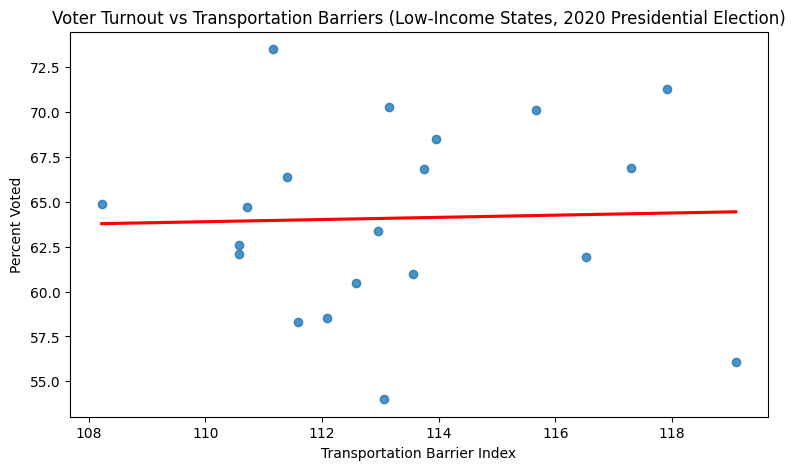

In [20]:
# scatterplot + regression line
plt.figure(figsize=(9,5))
sns.regplot(
    x = low_income_states['Transportation_Barrier_Index'],
    y = low_income_states['Percent_Voted_Citizen'],
    ci = None,
    line_kws={"color": "red"}
)
plt.title('Voter Turnout vs Transportation Barriers (Low-Income States, 2020 Presidential Election)')
plt.xlabel('Transportation Barrier Index')
plt.ylabel('Percent Voted')
plt.show();

### Choropleth

We want to create a choropleth that maps the transportation index barrier we calculated earlier, analyzing which states have the worst access to transportation according to the two variables we've defined (% no vehicle from home renters and % who don't use public transportation to commute to work).

In [21]:
# creating a choropleth map that visualizes our transportation barrier index by state
# darker colors represent worse access to transportation (higher index)

# match full State names to State abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# add a 'State_Abbrev' column for plotting
merged['State_Abbrev'] = merged['State'].map(state_abbreviations)

# make the choropleth map
# (plot each state shaded according to its Transportation Barrier Index)
fig = px.choropleth(
    merged,
    locations = 'State_Abbrev', # column with state abbreviations
    locationmode = "USA-states", # type of locations
    color = 'Transportation_Barrier_Index', # value to color by
    color_continuous_scale = "sunset", # color scale (darker = worse barriers)
    scope = "usa", # focus only on USA map
    title = 'Transportation Barrier Index by State (2020)' # develop title
)

fig.show();


In [22]:
# top 10 states with the highest transportation barrier index (worst access)
top_10_barriers = merged.sort_values('Transportation_Barrier_Index', ascending = False).head(10)

# top 10 states with the lowest transportation barrier index (best access)
bottom_10_barriers = merged.sort_values('Transportation_Barrier_Index', ascending = True).head(10)

print("Top 10 states with highest transportation barriers:")
print(top_10_barriers[['State', 'Transportation_Barrier_Index']])

print("\nTop 10 states with lowest transportation barriers:")
print(bottom_10_barriers[['State', 'Transportation_Barrier_Index']])

Top 10 states with highest transportation barriers:
            State  Transportation_Barrier_Index
31       New York                    125.444730
47  West Virginia                    119.095139
37   Pennsylvania                    118.932011
18          Maine                    117.918405
21       Michigan                    117.298166
20  Massachusetts                    117.250332
38   Rhode Island                    117.119918
17      Louisiana                    116.532739
44        Vermont                    116.441273
6     Connecticut                    116.056880

Top 10 states with lowest transportation barriers:
         State  Transportation_Barrier_Index
43        Utah                    106.998501
4   California                    107.798857
49     Wyoming                    107.896855
11       Idaho                    108.223149
5     Colorado                    108.468758
10      Hawaii                    108.675192
46  Washington                    109.134414
42      

The results show that New York has the highest transportation barrier index, making it a clear outlier in terms of limited transportation access, and Utah has the lowest transportation barrier index. In our later analysis, we delve into a county-level comparison, as the state-level analysis provides only a high-level overview and masks regional disparities within states.

### Barplot & Statistical Significance Test

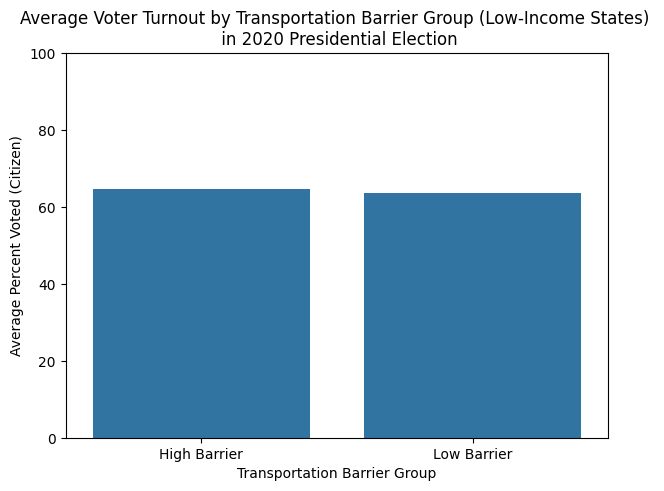

Barrier_Group  Percent_Voted_Citizen
0  High Barrier                  64.69
1   Low Barrier                  63.49

In [23]:
# calculating the mean transportation index barrier among low income states (defined earlier)
median_tbi = low_income_states['Transportation_Barrier_Index'].median()

# create a new group column: 'High Barrier' or 'Low Barrier'
# high barrier is for states that have an index above the median
# low barrier is for states that have an index below the median
# (among low income states - bottom 20 household incomes)
low_income_states['Barrier_Group'] = low_income_states['Transportation_Barrier_Index'].apply(
    lambda x: 'High Barrier' if x > median_tbi else 'Low Barrier'
)

# group by 'Barrier_Group' and calculate average turnout
# calculate the average voter turnout for each group
# this will let us compare average turnout across the two groups
group_means = low_income_states.groupby('Barrier_Group')['Percent_Voted_Citizen'].mean().reset_index()

# bar plot comparing turnout
# the barrier group is on the x axis
# the average turnout is on the y axis
plt.figure(figsize=(7,5))
sns.barplot(
    x='Barrier_Group',
    y='Percent_Voted_Citizen',
    data = group_means,
)
plt.title('Average Voter Turnout by Transportation Barrier Group (Low-Income States) \n in 2020 Presidential Election')
plt.xlabel('Transportation Barrier Group')
plt.ylabel('Average Percent Voted (Citizen)')
plt.ylim(0, 100)
plt.show();

group_means

In [24]:
low_income_states

State  Median_Income  Percent_Voted_Citizen  \
23     Mississippi        46511.0                   70.3   
47   West Virginia        48037.0                   56.1   
3         Arkansas        49475.0                   54.0   
17       Louisiana        50800.0                   61.9   
30      New Mexico        51243.0                   62.6   
0          Alabama        52035.0                   60.5   
16        Kentucky        52238.0                   68.5   
35        Oklahoma        53840.0                   58.3   
41       Tennessee        54833.0                   66.4   
39  South Carolina        54864.0                   63.4   
25         Montana        56539.0                   73.5   
32  North Carolina        56642.0                   64.7   
24        Missouri        57290.0                   66.8   
8          Florida        57703.0                   62.1   
34            Ohio        58116.0                   70.1   
13         Indiana        58235.0                   61.0   
11           Idaho        58915.0                   64.9   
21        Michigan        59234.0                   66.9   
18           Maine        59489.0                   71.3   
40    South Dakota        59896.0                   58.5   

    Pct_No_Vehicle_Renter  Public_Transport  Transportation_Barrier_Index  \
23              13.426466          0.270929                    113.155538   
47              19.928250          0.833111                    119.095139   
3               13.368011          0.305103                    113.062908   
17              17.624519          1.091780                    116.532739   
30              11.571590          0.992509                    110.579081   
0               12.918235          0.332189                    112.586047   
16              14.887520          0.932037                    113.955483   
35              11.953122          0.371188                    111.581934   
41              11.998242          0.601947                    111.396295   
39              13.473699          0.508767                    112.964931   
25              11.890475          0.728033                    111.162442   
32              11.676701          0.965454                    110.711247   
24              14.908238          1.157720                    113.750518   
8               12.195409          1.616987                    110.578421   
34              17.104202          1.440745                    115.663457   
13              14.437926          0.880363                    113.557563   
11               8.860226          0.637078                    108.223149   
21              18.583939          1.285773                    117.298166   
18              18.460404          0.541999                    117.918405   
40              12.541411          0.463571                    112.077840   

   Barrier_Group  
23  High Barrier  
47  High Barrier  
3   High Barrier  
17  High Barrier  
30   Low Barrier  
0    Low Barrier  
16  High Barrier  
35   Low Barrier  
41   Low Barrier  
39   Low Barrier  
25   Low Barrier  
32   Low Barrier  
24  High Barrier  
8    Low Barrier  
34  High Barrier  
13  High Barrier  
11   Low Barrier  
21  High Barrier  
18  High Barrier  
40   Low Barrier

This shows that Mississippi has the lowest median income (and is high barrier). The state that is the lowest income that is low barrier is New Mexico. Thus, in our later county-level analyes, this information informed our decisino to choose counties within these two states.

In [25]:
# run a simple statistical test (independent two sample t test) to check if voter turnout
# is signficiantly different between high and low barrier groups

# split the turnout data
high_barrier_turnout = low_income_states[low_income_states['Barrier_Group'] == 'High Barrier']['Percent_Voted_Citizen']
low_barrier_turnout = low_income_states[low_income_states['Barrier_Group'] == 'Low Barrier']['Percent_Voted_Citizen']

# run an independent two-sample t-test
# this tests whether the mean voter turnout differs significantly
# between the high and low barrier groups
t_stat, p_value = ttest_ind(high_barrier_turnout, low_barrier_turnout)

# print t-test results
print(f"p value: {p_value:.4f}")

p value: 0.6214


The high p value calculated of 0.6214 indicates that there is no statistically significant difference in voter turnout between the High Barrier and Low Barrier groups among low-income states.

This suggests that, in this sample, based on our data and created index, transportation barriers as measured (using the transportation barrier index) may not be strongly associated with differences in voter turnout in the 2020 presidential election.

# Case Study: County-Level Analysis
## Holmes, MS and McKinley, NM

In [26]:
!pip install -q census us folium geopandas colorcet

In [27]:
%config InlineBackend.figure_formats = ["retina"]

import geopandas as gpd
import folium
import colorcet as cc
from urllib.request import urlretrieve
import os

from census import Census

In [28]:
census = Census("", year=2020)

# Low income States - Mississipi and New Mexico

# Mississippi

In [29]:
temp_file = "temp_ms_tracts_2020.zip"
urlretrieve("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_28_tract.zip", temp_file)

ms_tract_gdf_2020 = gpd.read_file(temp_file).set_index("GEOID").to_crs("EPSG:2163")

os.remove(temp_file)

In [30]:
ms_tract_gdf_2020.head(5)

STATEFP COUNTYFP TRACTCE     NAME              NAMELSAD  MTFCC  \
GEOID                                                                        
28067950402      28      067  950402  9504.02  Census Tract 9504.02  G5020   
28067950302      28      067  950302  9503.02  Census Tract 9503.02  G5020   
28067950301      28      067  950301  9503.01  Census Tract 9503.01  G5020   
28067950401      28      067  950401  9504.01  Census Tract 9504.01  G5020   
28017950100      28      017  950100     9501     Census Tract 9501  G5020   

            FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                
28067950402        S   10594077   20292  +31.7301953  -089.1274582   
28067950302        S   60231403  319304  +31.6842819  -089.2203469   
28067950301        S  209387458  967911  +31.6804102  -089.3240145   
28067950401        S   14709284  111085  +31.7296837  -089.1610441   
28017950100        S  167130323  572181  +34.0138193  -088.7972205   

                                                      geometry  
GEOID                                                           
28067950402  POLYGON ((1029116.112 -1404725.602, 1029136.46...  
28067950302  POLYGON ((1017204.413 -1408766.96, 1017394.491...  
28067950301  POLYGON ((1005770.734 -1407579.112, 1005785.13...  
28067950401  POLYGON ((1026323.05 -1407640.153, 1026315.572...  
28017950100  POLYGON ((1024579.69 -1153481.657, 1024588.48 ...

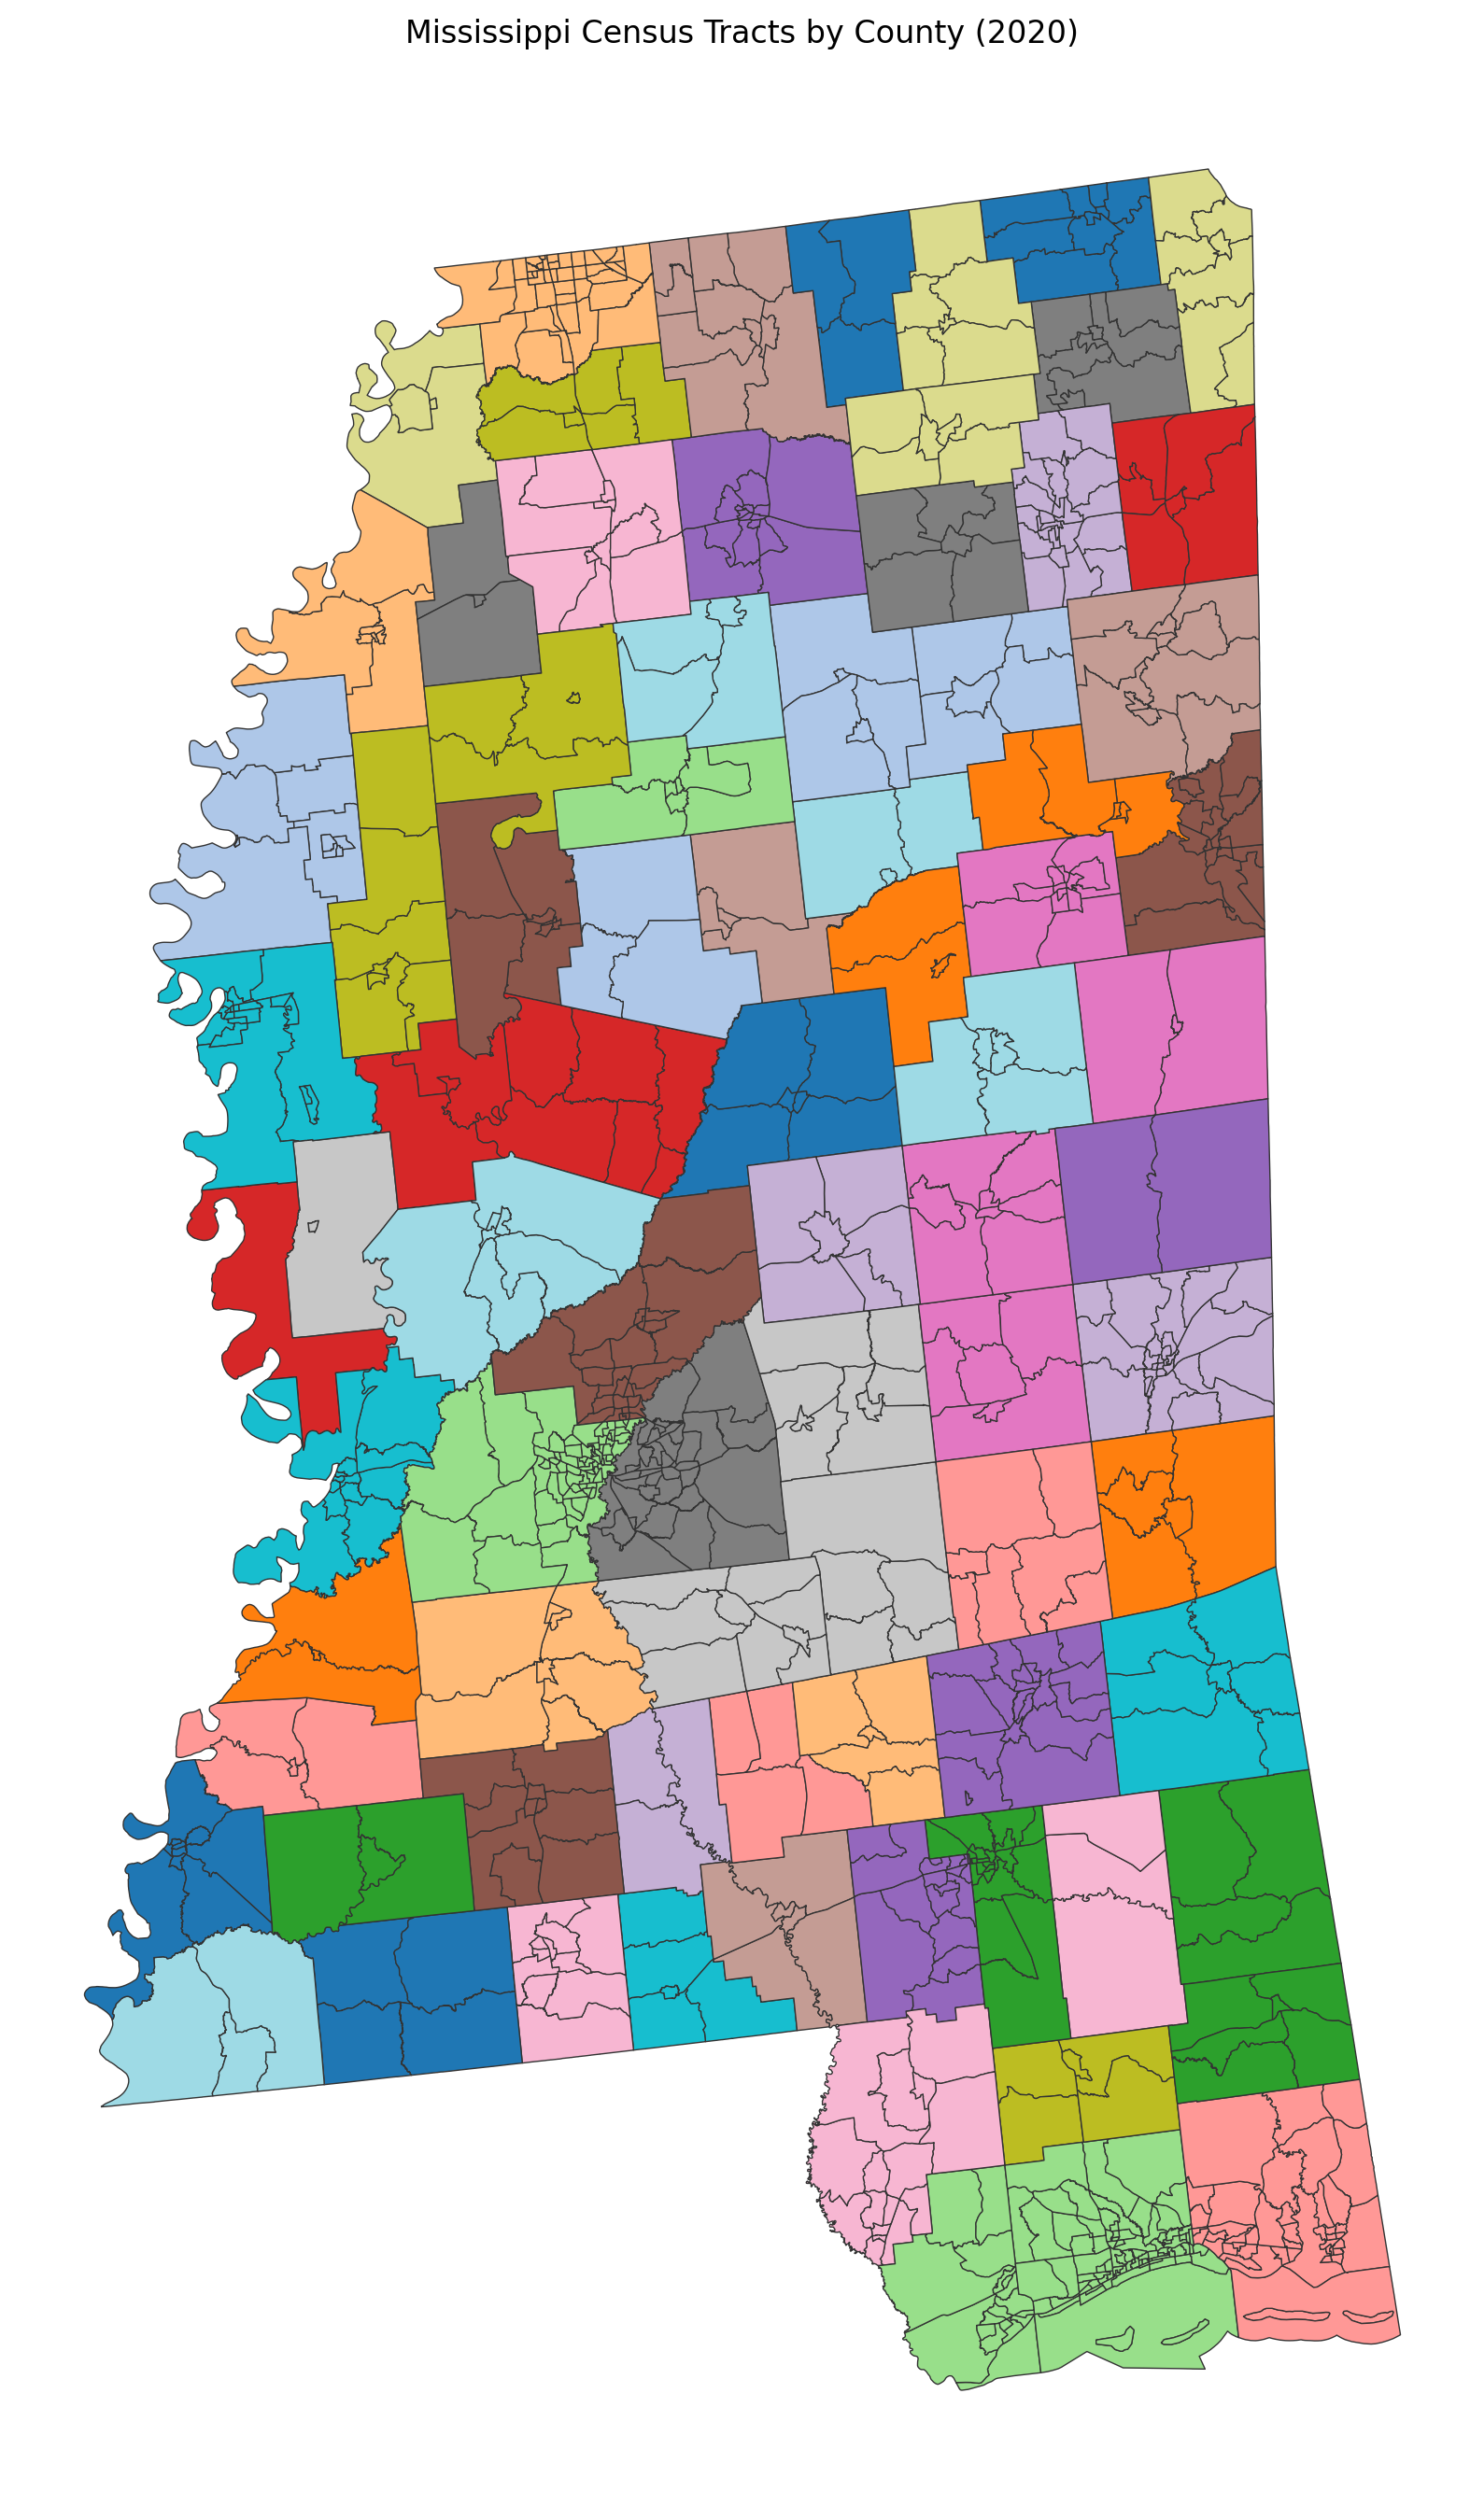

In [31]:
ms_tract_gdf_2020.plot(
    figsize=(10, 20),
    column="COUNTYFP",
    cmap="tab20",
    edgecolor="0.2",
    linewidth=0.5
)
plt.axis("off")
plt.title("Mississippi Census Tracts by County (2020)")
plt.show()

filter

In [32]:
# interested in holmes county in MS
holmes_tract_gdf = ms_tract_gdf_2020[ms_tract_gdf_2020["COUNTYFP"] == "051"]

In [33]:
holmes_tract_gdf.head()

STATEFP COUNTYFP TRACTCE     NAME              NAMELSAD  MTFCC  \
GEOID                                                                        
28051950200      28      051  950200     9502     Census Tract 9502  G5020   
28051950100      28      051  950100     9501     Census Tract 9501  G5020   
28051950400      28      051  950400     9504     Census Tract 9504  G5020   
28051950501      28      051  950501  9505.01  Census Tract 9505.01  G5020   
28051950502      28      051  950502  9505.02  Census Tract 9505.02  G5020   

            FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                 
28051950200        S  438434488  1432523  +33.1998802  -090.0448204   
28051950100        S  345396756   898674  +33.1407707  -089.8822124   
28051950400        S  499573016  9584678  +33.0448154  -090.2263023   
28051950501        S   78183707   782806  +32.9382480  -089.9414171   
28051950502        S  228155766   963864  +32.9953135  -090.0286468   

                                                      geometry  
GEOID                                                           
28051950200  POLYGON ((915319.301 -1264072.959, 915323.082 ...  
28051950100  POLYGON ((937882.567 -1270228.045, 937919.2 -1...  
28051950400  POLYGON ((893847.521 -1271101.427, 893854.923 ...  
28051950501  POLYGON ((934771.832 -1288523.784, 934813.639 ...  
28051950502  POLYGON ((925623.041 -1285917.411, 925683.07 -...

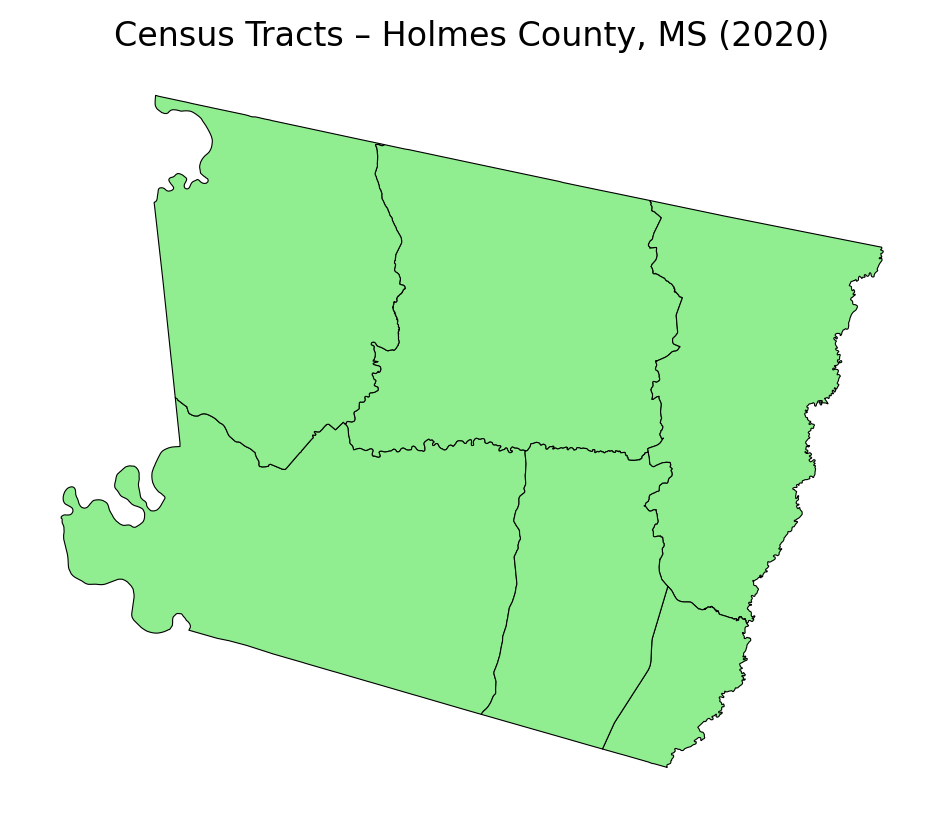

In [34]:
# plotting the census tracts of Holmes county
holmes_tract_gdf.plot(
    edgecolor="black",
    linewidth=0.4,
    color="lightgreen"
)
plt.title("Census Tracts – Holmes County, MS (2020)")
plt.axis("off")
plt.show()

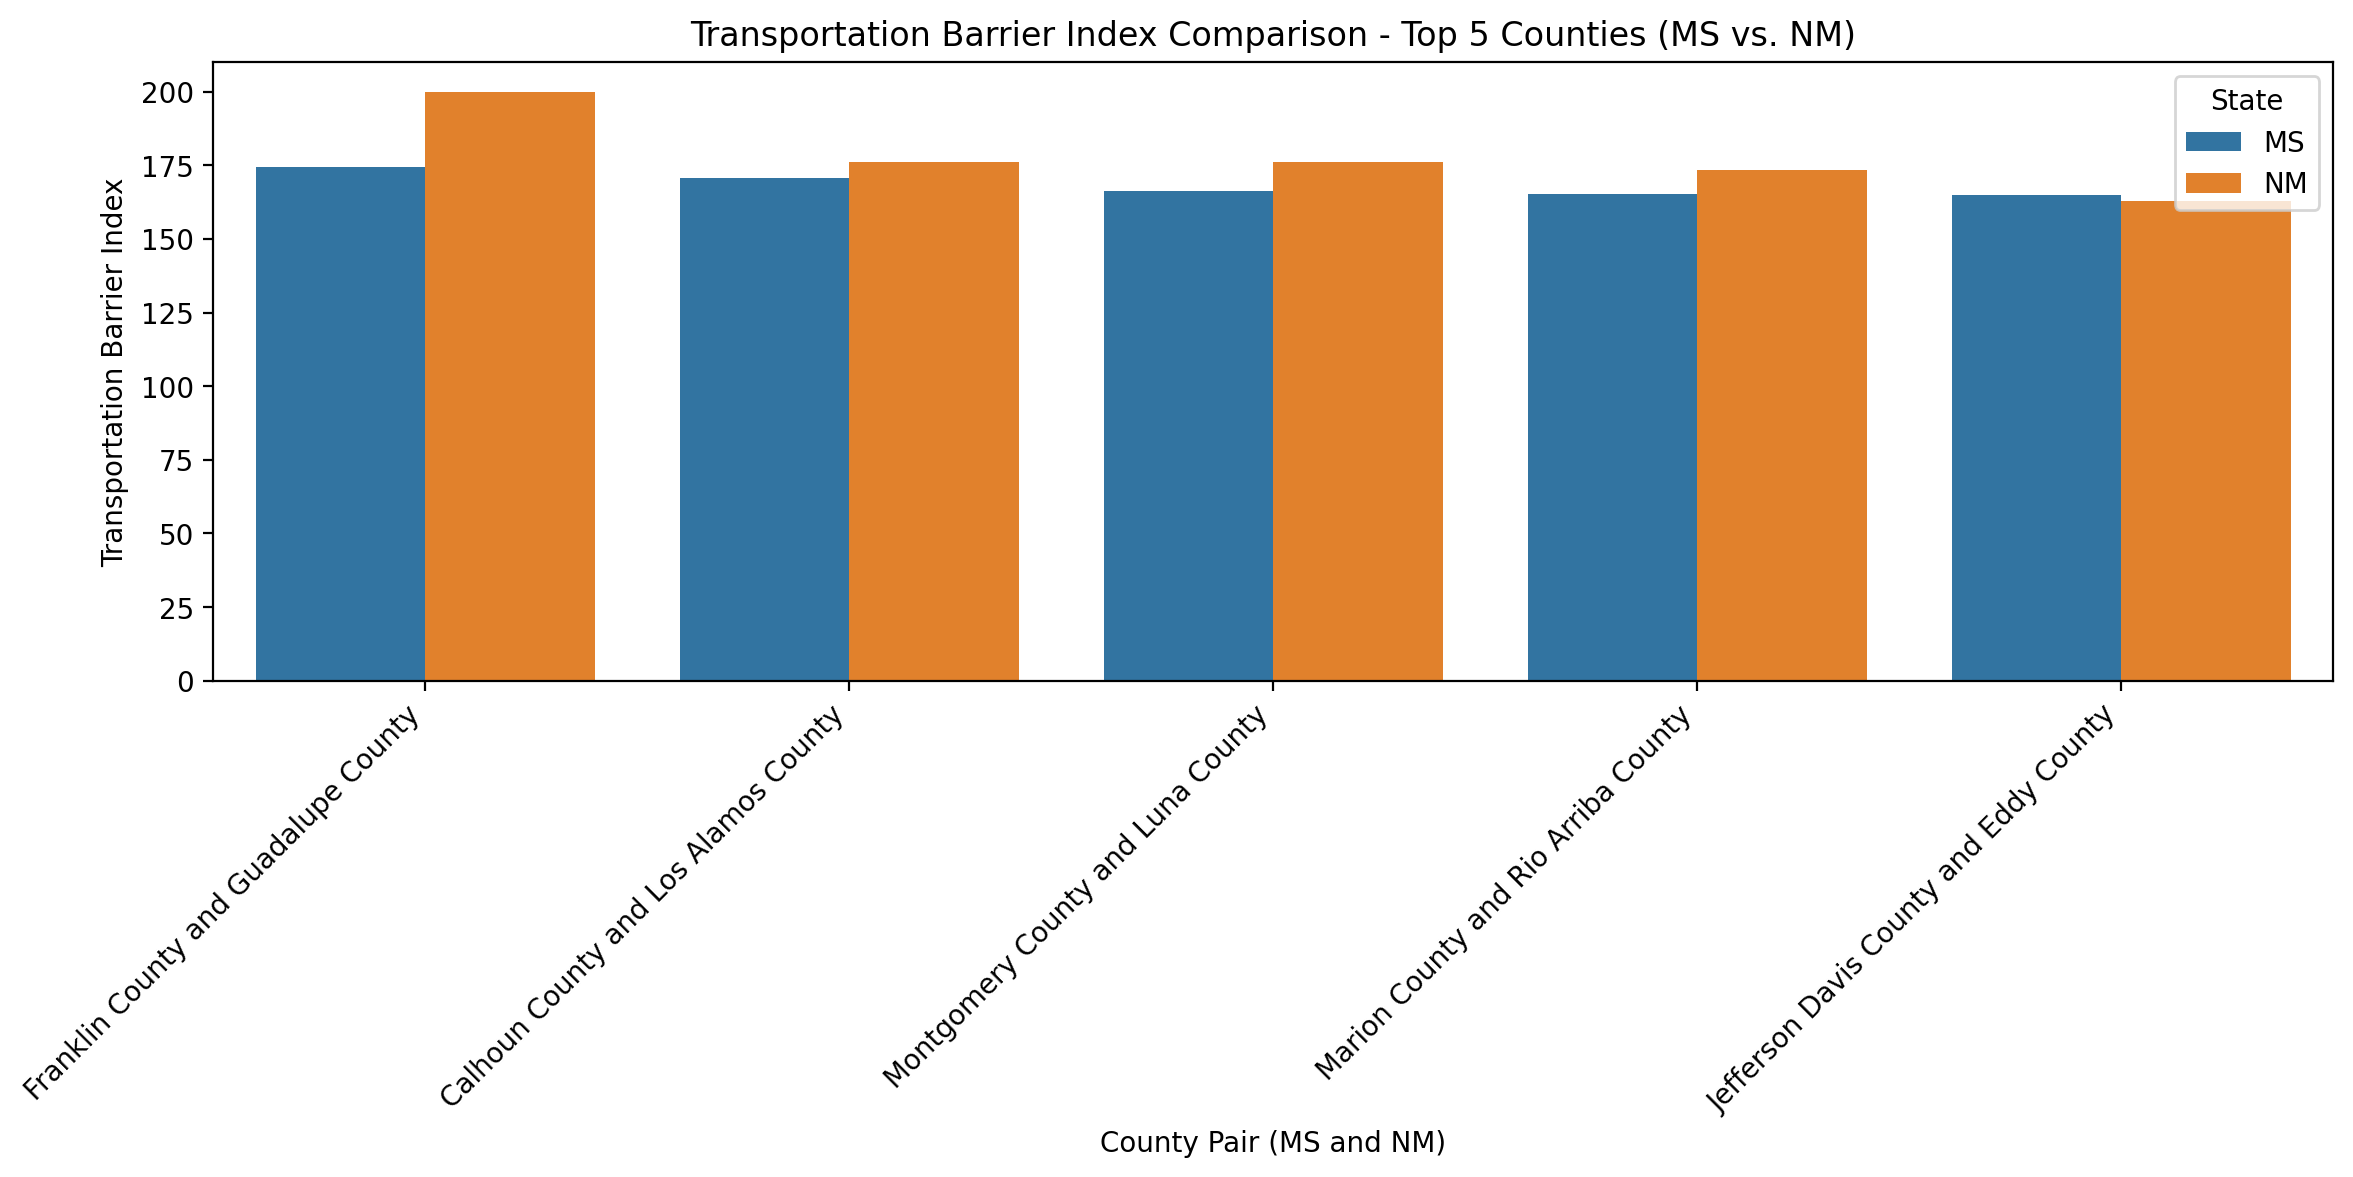

In [35]:
census = Census("", year=2020)

# load fips-to-county name mapping for later merging
fips_df = pd.read_csv(
    "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt",
    header=None,
    dtype=str
)
fips_df.columns = ["STATE", "STATEFP", "COUNTYFP", "COUNTYNAME", "CLASSFP"]
fips_df = fips_df[["STATEFP", "COUNTYFP", "COUNTYNAME"]]
fips_df["FIPS"] = fips_df["STATEFP"] + fips_df["COUNTYFP"]

# function to get county-level transportation barrier index using acs + TIGER data
def calculate_tbi_by_county(state_fips, state_name):

    # download and unzip shapefile for the state
    temp_file = f"temp_{state_name.lower()}_tracts_2020.zip"
    urlretrieve(f"https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_{state_fips}_tract.zip", temp_file)
    tract_gdf_2020 = gpd.read_file(temp_file).set_index("GEOID").to_crs("EPSG:2163")
    os.remove(temp_file)

    # get household-level vehicle access data
    household_data = census.acs5.get(
        ("B25044_007E", "B25044_008E"),  # Total and no-vehicle households
        geo={"for": "tract:*", "in": f"state:{state_fips}"},
    )

    # get commuting method data (to find % using public transport)
    public_transport_data = census.acs5.get(
        ("B08301_001E", "B08301_010E"),  # Total workers and public transport users
        geo={"for": "tract:*", "in": f"state:{state_fips}"},
    )

    # create dataframe for household data
    household_df = pd.DataFrame(household_data).rename(
        columns={"B25044_007E": "total_households", "B25044_008E": "no_vehicle_households"}
    )
    household_df["GEOID"] = household_df["state"] + household_df["county"] + household_df["tract"]
    household_df = household_df.set_index("GEOID")

    # create dataframe for public transport data
    public_transport_df = pd.DataFrame(public_transport_data).rename(
        columns={"B08301_001E": "total_workers", "B08301_010E": "public_transport_users"}
    )
    public_transport_df["GEOID"] = public_transport_df["state"] + public_transport_df["county"] + public_transport_df["tract"]
    public_transport_df = public_transport_df.set_index("GEOID")

    # merge census data into tract shapefile
    tract_gdf_2020 = tract_gdf_2020.merge(household_df, on='GEOID', how='left')
    tract_gdf_2020 = tract_gdf_2020.merge(public_transport_df, on='GEOID', how='left')

    # convert all count columns to numeric
    for col in ["total_households", "no_vehicle_households", "total_workers", "public_transport_users"]:
        tract_gdf_2020[col] = pd.to_numeric(tract_gdf_2020[col], errors="coerce")

    # filter out tracts with small populations or nulls
    tract_gdf_2020 = tract_gdf_2020[
        (tract_gdf_2020["total_households"] > 10) &
        (tract_gdf_2020["total_workers"] > 10) &
        tract_gdf_2020["no_vehicle_households"].notnull() &
        tract_gdf_2020["public_transport_users"].notnull()
    ]

    # calculate % no car and % using public transport
    tract_gdf_2020["no_vehicle_pct"] = 100 * tract_gdf_2020["no_vehicle_households"] / tract_gdf_2020["total_households"]
    tract_gdf_2020["public_transport_pct"] = 100 * tract_gdf_2020["public_transport_users"] / tract_gdf_2020["total_workers"]

    # cap values between 0 and 100 to clean data
    tract_gdf_2020["no_vehicle_pct"] = tract_gdf_2020["no_vehicle_pct"].clip(0, 100)
    tract_gdf_2020["public_transport_pct"] = tract_gdf_2020["public_transport_pct"].clip(0, 100)

    # compute transportation barrier index for each tract
    tract_gdf_2020["Transportation_Barrier_Index"] = (
        tract_gdf_2020["no_vehicle_pct"] + (100 - tract_gdf_2020["public_transport_pct"])
    )

    # calculate average Transportation Barrier Index for each county
    tract_gdf_2020["COUNTYFP"] = tract_gdf_2020["COUNTYFP"].astype(str)
    county_tbi = tract_gdf_2020.groupby("COUNTYFP")["Transportation_Barrier_Index"].mean().reset_index()
    county_tbi["STATEFP"] = state_fips
    county_tbi["FIPS"] = county_tbi["STATEFP"] + county_tbi["COUNTYFP"]

    return county_tbi

# calculate county-level Transportation Barrier Index for MS and NM
ms_county_tbi = calculate_tbi_by_county("28", "Mississippi")
nm_county_tbi = calculate_tbi_by_county("35", "New Mexico")

# merge with county name labels
ms_county_tbi = ms_county_tbi.merge(fips_df[["FIPS", "COUNTYNAME"]], on="FIPS", how="left").rename(columns={"COUNTYNAME": "County_MS"})
nm_county_tbi = nm_county_tbi.merge(fips_df[["FIPS", "COUNTYNAME"]], on="FIPS", how="left").rename(columns={"COUNTYNAME": "County_NM"})

# get top 5 counties with highest Transportation Barrier Index in each state
top_5_ms = ms_county_tbi.sort_values("Transportation_Barrier_Index", ascending=False).head(5).reset_index(drop=True)
top_5_ms["Rank"] = top_5_ms.index + 1
top_5_nm = nm_county_tbi.sort_values("Transportation_Barrier_Index", ascending=False).head(5).reset_index(drop=True)
top_5_nm["Rank"] = top_5_nm.index + 1

# merge top 5 for both states for plotting
combined = pd.merge(
    top_5_ms[["Rank", "County_MS", "Transportation_Barrier_Index"]],
    top_5_nm[["Rank", "County_NM", "Transportation_Barrier_Index"]],
    on="Rank",
    suffixes=("_MS", "_NM")
)

# format labels and reshape data for seaborn barplot
combined["Label"] = combined["County_MS"] + " and " + combined["County_NM"]
melted = pd.melt(
    combined,
    id_vars=["Rank", "Label"],
    value_vars=["Transportation_Barrier_Index_MS", "Transportation_Barrier_Index_NM"],
    var_name="State",
    value_name="TBI"
)
melted["State"] = melted["State"].str.extract(r"_(MS|NM)$")

# create grouped barplot comparing Transportation Barrier Index across counties
plt.figure(figsize=(12, 6))
sns.barplot(x="Label", y="TBI", hue="State", data=melted)
plt.title("Transportation Barrier Index Comparison - Top 5 Counties (MS vs. NM)")
plt.xlabel("County Pair (MS and NM)")
plt.ylabel("Transportation Barrier Index")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# ACS Data

In [36]:
holmes_car_acs_raw = census.acs5.get(
    (
        "B08201_001E",  # Total households
        "B08201_002E",  # Households with no vehicle
    ),
    geo={"for": "tract:*", "in": "state:28 county:051"},
    year=2020,
)

In [37]:
# Convert to DataFrame and rename columns
holmes_car_df = pd.DataFrame(holmes_car_acs_raw).rename(
    columns={
        "B08201_001E": "total_households",
        "B08201_002E": "no_vehicle_households"
    }
)

# Construct GEOID for joining with tract shapefile
holmes_car_df["GEOID"] = holmes_car_df["state"] + holmes_car_df["county"] + holmes_car_df["tract"]
holmes_car_df = holmes_car_df.set_index("GEOID")

# Calculate percent of households with no vehicle
holmes_car_df["no_vehicle_pct"] = (
    100 * holmes_car_df["no_vehicle_households"].astype(float) /
    holmes_car_df["total_households"].astype(float)
)

# Drop tracts with 0 households to avoid division errors
holmes_car_df = holmes_car_df[holmes_car_df["total_households"].astype(float) > 0]

In [38]:
holmes_car_df

total_households  no_vehicle_households state county   tract  \
GEOID                                                                       
28051950100            1616.0                  265.0    28    051  950100   
28051950200            1269.0                   62.0    28    051  950200   
28051950300            1135.0                  203.0    28    051  950300   
28051950400             752.0                  109.0    28    051  950400   
28051950501             975.0                  167.0    28    051  950501   
28051950502             611.0                  117.0    28    051  950502   

             no_vehicle_pct  
GEOID                        
28051950100       16.398515  
28051950200        4.885737  
28051950300       17.885463  
28051950400       14.494681  
28051950501       17.128205  
28051950502       19.148936

In [39]:
holmes_car_gdf = holmes_tract_gdf.join(holmes_car_df)

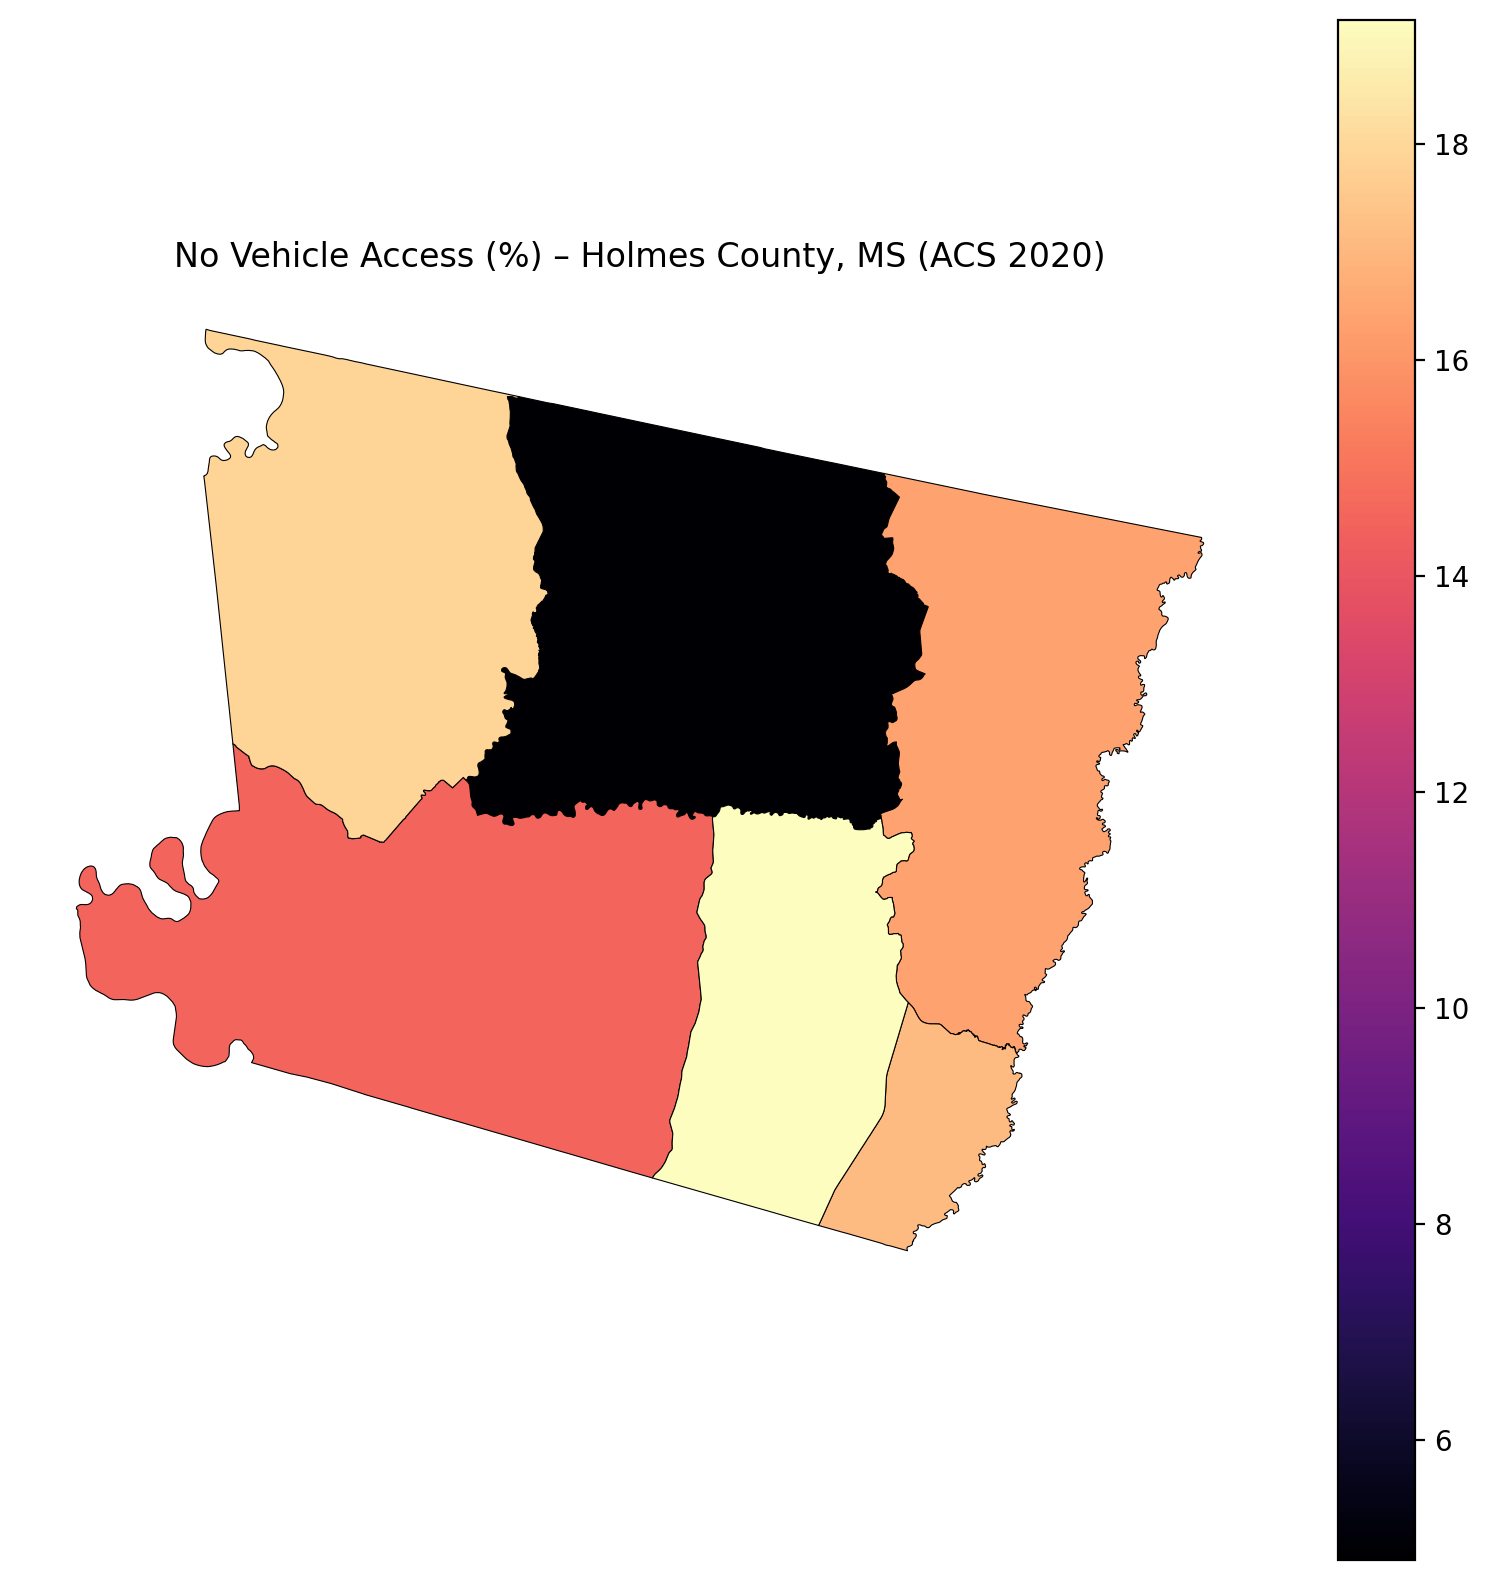

In [40]:
# plotting holmes county by tract
# by the percentage of those who do not have vehicle access

holmes_car_gdf.plot(
    figsize=(10, 10),
    column="no_vehicle_pct",
    cmap="magma",
    edgecolor="black",
    linewidth=0.4,
    legend=True
)
plt.axis("off")
plt.title("No Vehicle Access (%) – Holmes County, MS (ACS 2020)")
plt.show()

In [41]:
holmes_income_raw = census.acs5.get(
    ("B19013_001E",),  # Median household income
    geo={"for": "tract:*", "in": "state:28 county:051"},
    year=2020,
)

# Convert to DataFrame and rename columns
holmes_income_df = pd.DataFrame(holmes_income_raw).rename(
    columns={"B19013_001E": "median_income"}
)

# Construct GEOID to match shapefile index
holmes_income_df["GEOID"] = holmes_income_df["state"] + holmes_income_df["county"] + holmes_income_df["tract"]
holmes_income_df = holmes_income_df.set_index("GEOID")

# Convert income to float
holmes_income_df["median_income"] = holmes_income_df["median_income"].astype(float)

# Join with Holmes County tract shapefile
holmes_income_gdf = holmes_tract_gdf.join(holmes_income_df)


In [42]:
holmes_income_gdf

STATEFP COUNTYFP TRACTCE     NAME              NAMELSAD  MTFCC  \
GEOID                                                                        
28051950200      28      051  950200     9502     Census Tract 9502  G5020   
28051950100      28      051  950100     9501     Census Tract 9501  G5020   
28051950400      28      051  950400     9504     Census Tract 9504  G5020   
28051950501      28      051  950501  9505.01  Census Tract 9505.01  G5020   
28051950502      28      051  950502  9505.02  Census Tract 9505.02  G5020   
28051950300      28      051  950300     9503     Census Tract 9503  G5020   

            FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                 
28051950200        S  438434488  1432523  +33.1998802  -090.0448204   
28051950100        S  345396756   898674  +33.1407707  -089.8822124   
28051950400        S  499573016  9584678  +33.0448154  -090.2263023   
28051950501        S   78183707   782806  +32.9382480  -089.9414171   
28051950502        S  228155766   963864  +32.9953135  -090.0286468   
28051950300        S  370033097  6906280  +33.2428717  -090.2358422   

                                                      geometry  median_income  \
GEOID                                                                           
28051950200  POLYGON ((915319.301 -1264072.959, 915323.082 ...        30014.0   
28051950100  POLYGON ((937882.567 -1270228.045, 937919.2 -1...        21543.0   
28051950400  POLYGON ((893847.521 -1271101.427, 893854.923 ...        28100.0   
28051950501  POLYGON ((934771.832 -1288523.784, 934813.639 ...        22486.0   
28051950502  POLYGON ((925623.041 -1285917.411, 925683.07 -...   -666666666.0   
28051950300  POLYGON ((900862.302 -1247296.613, 900905.211 ...        27644.0   

            state county   tract  
GEOID                             
28051950200    28    051  950200  
28051950100    28    051  950100  
28051950400    28    051  950400  
28051950501    28    051  950501  
28051950502    28    051  950502  
28051950300    28    051  950300

In [43]:
# Pull commute mode and travel time data (B08014) from ACS
holmes_commute_raw = census.acs5.get(
    (
        "B08014_001E",  # Total workers 16+ years
        "B08014_010E",  # Public transportation (excluding taxicab): Less than 30 minutes
        "B08014_011E",  # Public transportation: 30 to 59 minutes
        "B08014_012E",  # Public transportation: 60 or more minutes
    ),
    geo={"for": "tract:*", "in": "state:28 county:051"},
    year=2020,
)

# Convert to DataFrame
holmes_commute_df = pd.DataFrame(holmes_commute_raw).rename(columns={
    "B08014_001E": "total_workers",
    "B08014_010E": "public_transit_lt_30",
    "B08014_011E": "public_transit_30_59",
    "B08014_012E": "public_transit_60_plus"
})

# Construct GEOID to match tract shapefile
holmes_commute_df["GEOID"] = holmes_commute_df["state"] + holmes_commute_df["county"] + holmes_commute_df["tract"]
holmes_commute_df = holmes_commute_df.set_index("GEOID")

# Convert to numeric
for col in ["total_workers", "public_transit_lt_30", "public_transit_30_59", "public_transit_60_plus"]:
    holmes_commute_df[col] = holmes_commute_df[col].astype(float)

# Calculate total public transit users
holmes_commute_df["public_transit_total"] = (
    holmes_commute_df["public_transit_lt_30"] +
    holmes_commute_df["public_transit_30_59"] +
    holmes_commute_df["public_transit_60_plus"]
)

# Compute % of workers using public transportation
holmes_commute_df["pct_public_transit"] = (
    100 * holmes_commute_df["public_transit_total"] /
    holmes_commute_df["total_workers"]
)

# Drop rows where total_workers is zero
holmes_commute_df = holmes_commute_df[holmes_commute_df["total_workers"] > 0]


In [44]:
holmes_commute_df

total_workers  public_transit_lt_30  public_transit_30_59  \
GEOID                                                                    
28051950100         1223.0                 171.0                 230.0   
28051950200         1062.0                  73.0                 153.0   
28051950300          647.0                  72.0                 134.0   
28051950400          650.0                  45.0                  78.0   
28051950501          838.0                  40.0                 202.0   
28051950502          445.0                  41.0                 133.0   

             public_transit_60_plus state county   tract  \
GEOID                                                      
28051950100                    16.0    28    051  950100   
28051950200                    97.0    28    051  950200   
28051950300                    33.0    28    051  950300   
28051950400                    42.0    28    051  950400   
28051950501                    75.0    28    051  950501   
28051950502                    14.0    28    051  950502   

             public_transit_total  pct_public_transit  
GEOID                                                  
28051950100                 417.0           34.096484  
28051950200                 323.0           30.414313  
28051950300                 239.0           36.939722  
28051950400                 165.0           25.384615  
28051950501                 317.0           37.828162  
28051950502                 188.0           42.247191

# MS Polling Data

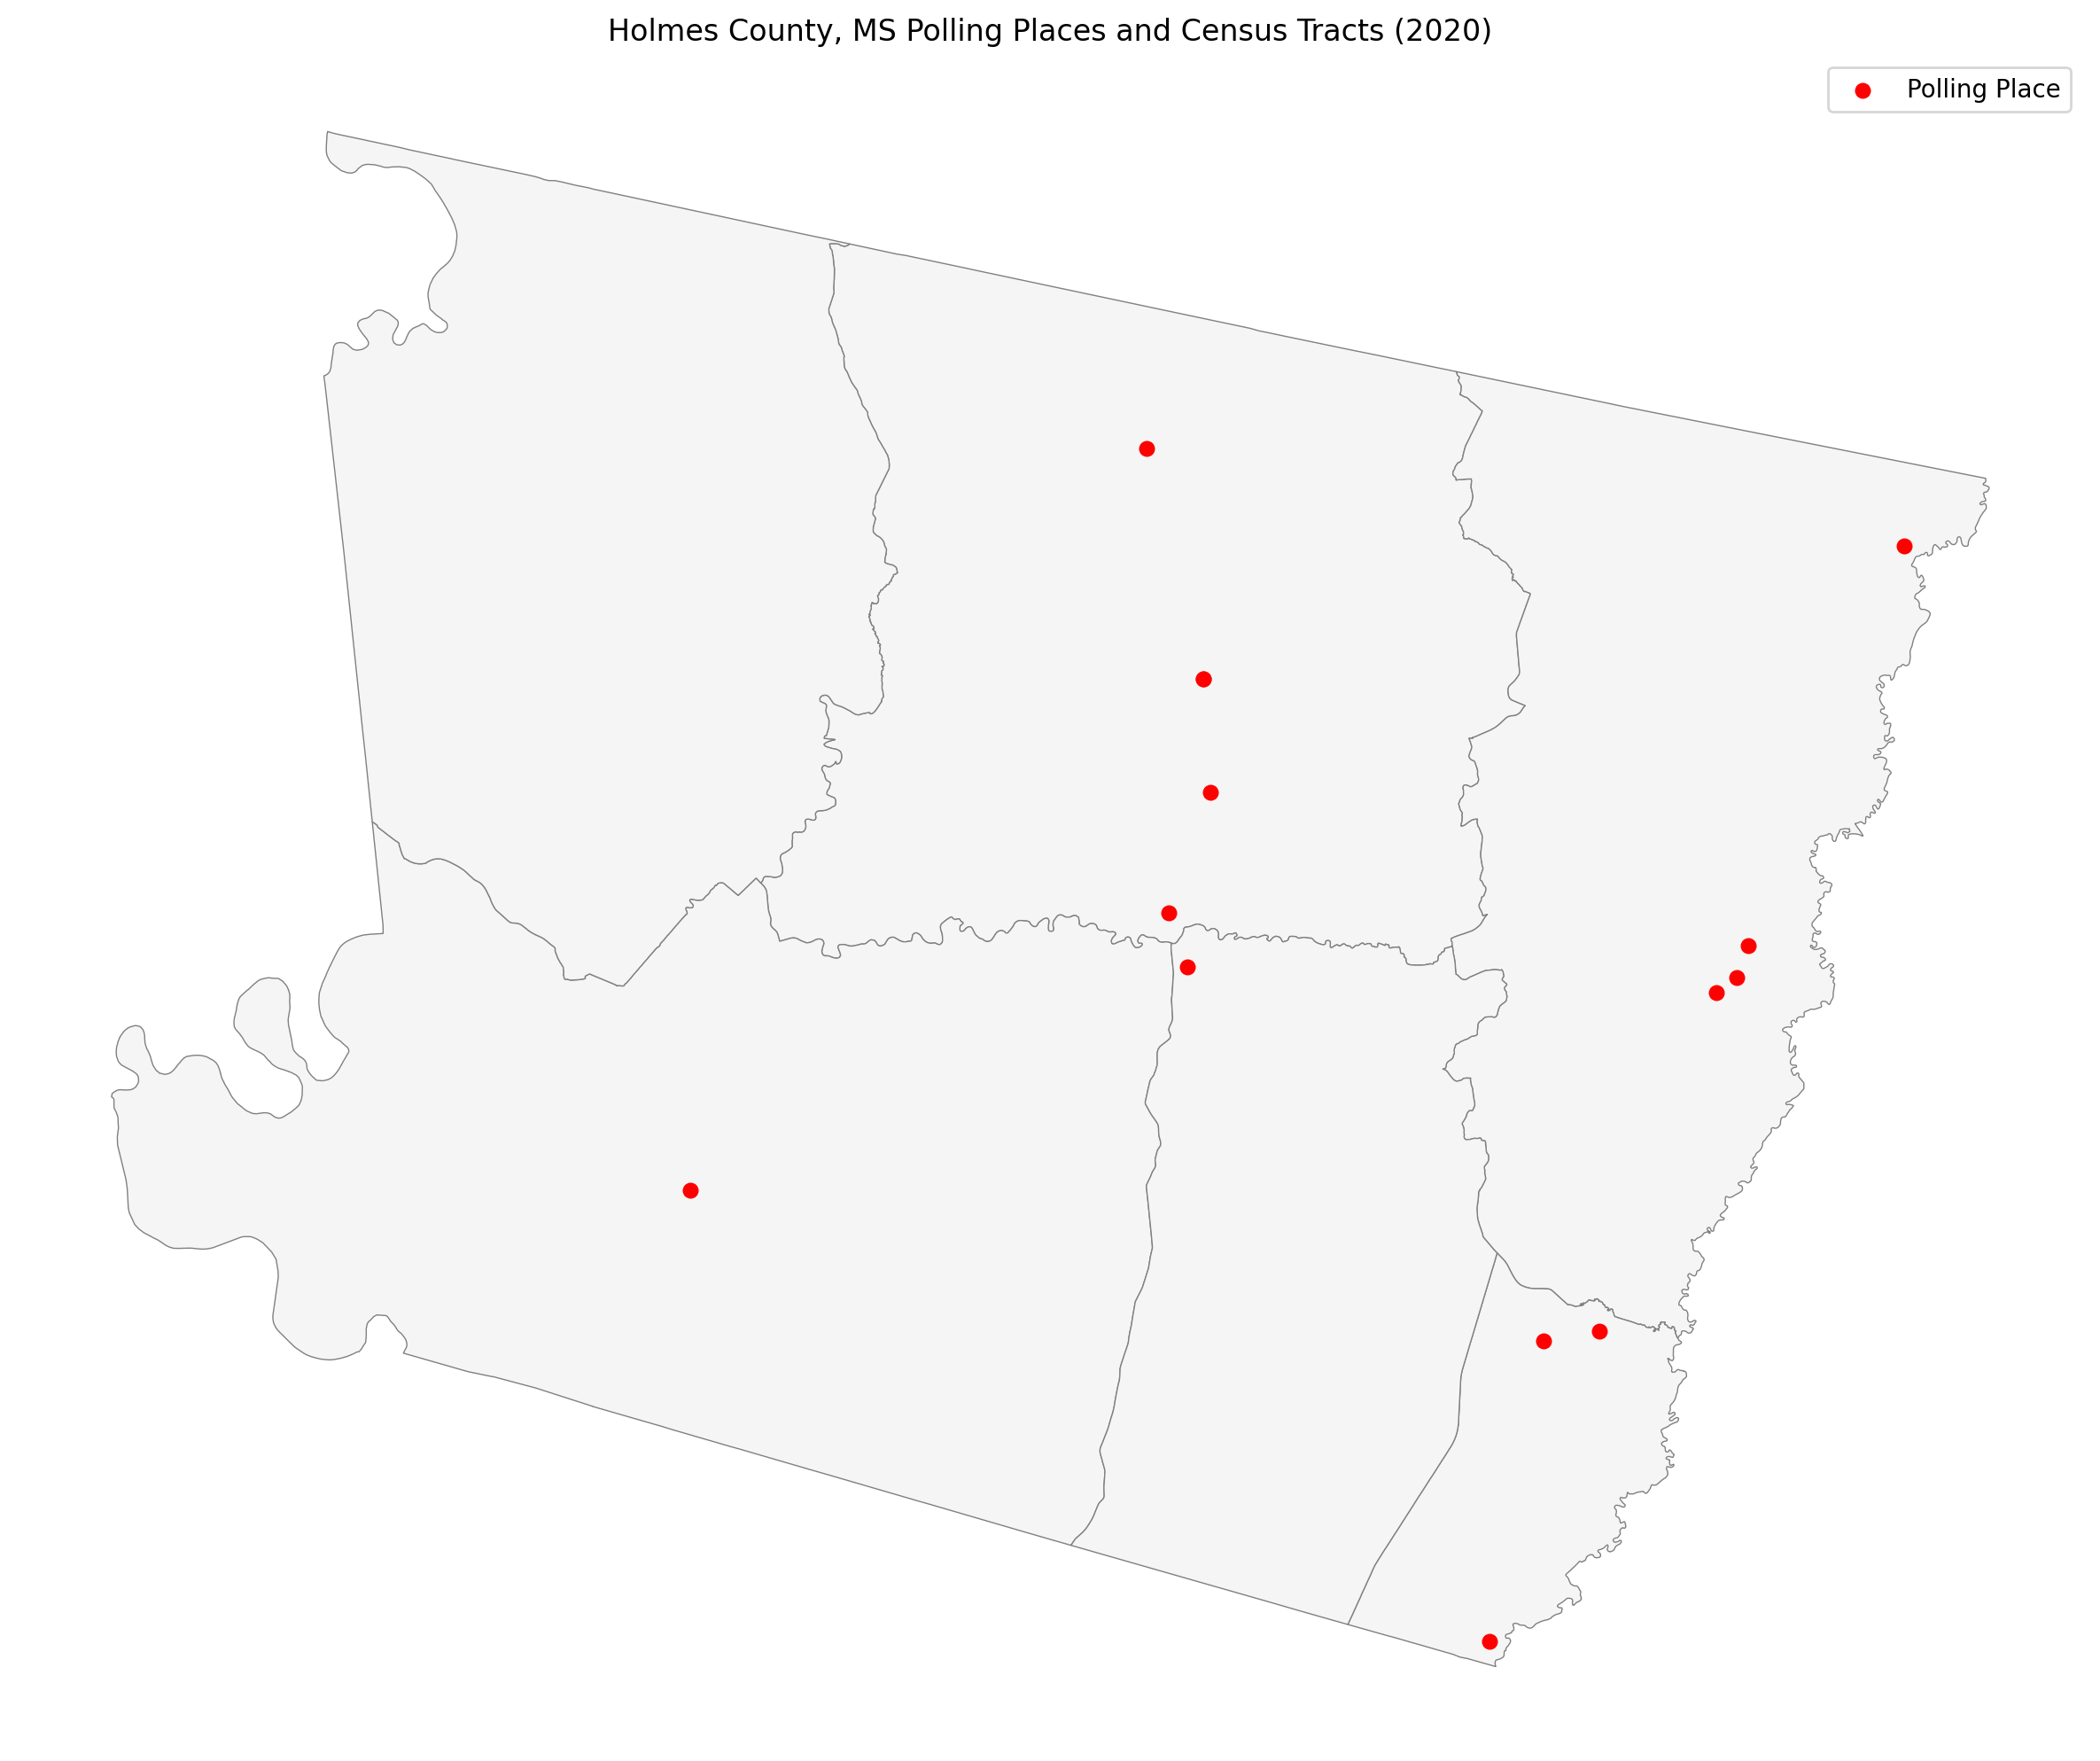

In [45]:
# Load geocoded polling places
polling_df = pd.read_csv("https://raw.githubusercontent.com/PUBPOL-2130/projects/main/E2/holmes_geocoded_polling%200011.csv")
polling_gdf = gpd.GeoDataFrame(
    polling_df,
    geometry=gpd.points_from_xy(polling_df.longitude, polling_df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=2163)

# Filter Holmes County tracts from previously loaded 2020 shapefile
holmes_tracts_gdf = ms_tract_gdf_2020[ms_tract_gdf_2020["COUNTYFP"] == "051"]

# Plot census tracts and polling places
fig, ax = plt.subplots(figsize=(12, 10))
holmes_tracts_gdf.plot(ax=ax, color='whitesmoke', edgecolor='gray', linewidth=0.5)
polling_gdf.plot(ax=ax, color='red', markersize=30, marker='o', label='Polling Place')

plt.title("Holmes County, MS Polling Places and Census Tracts (2020)")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()

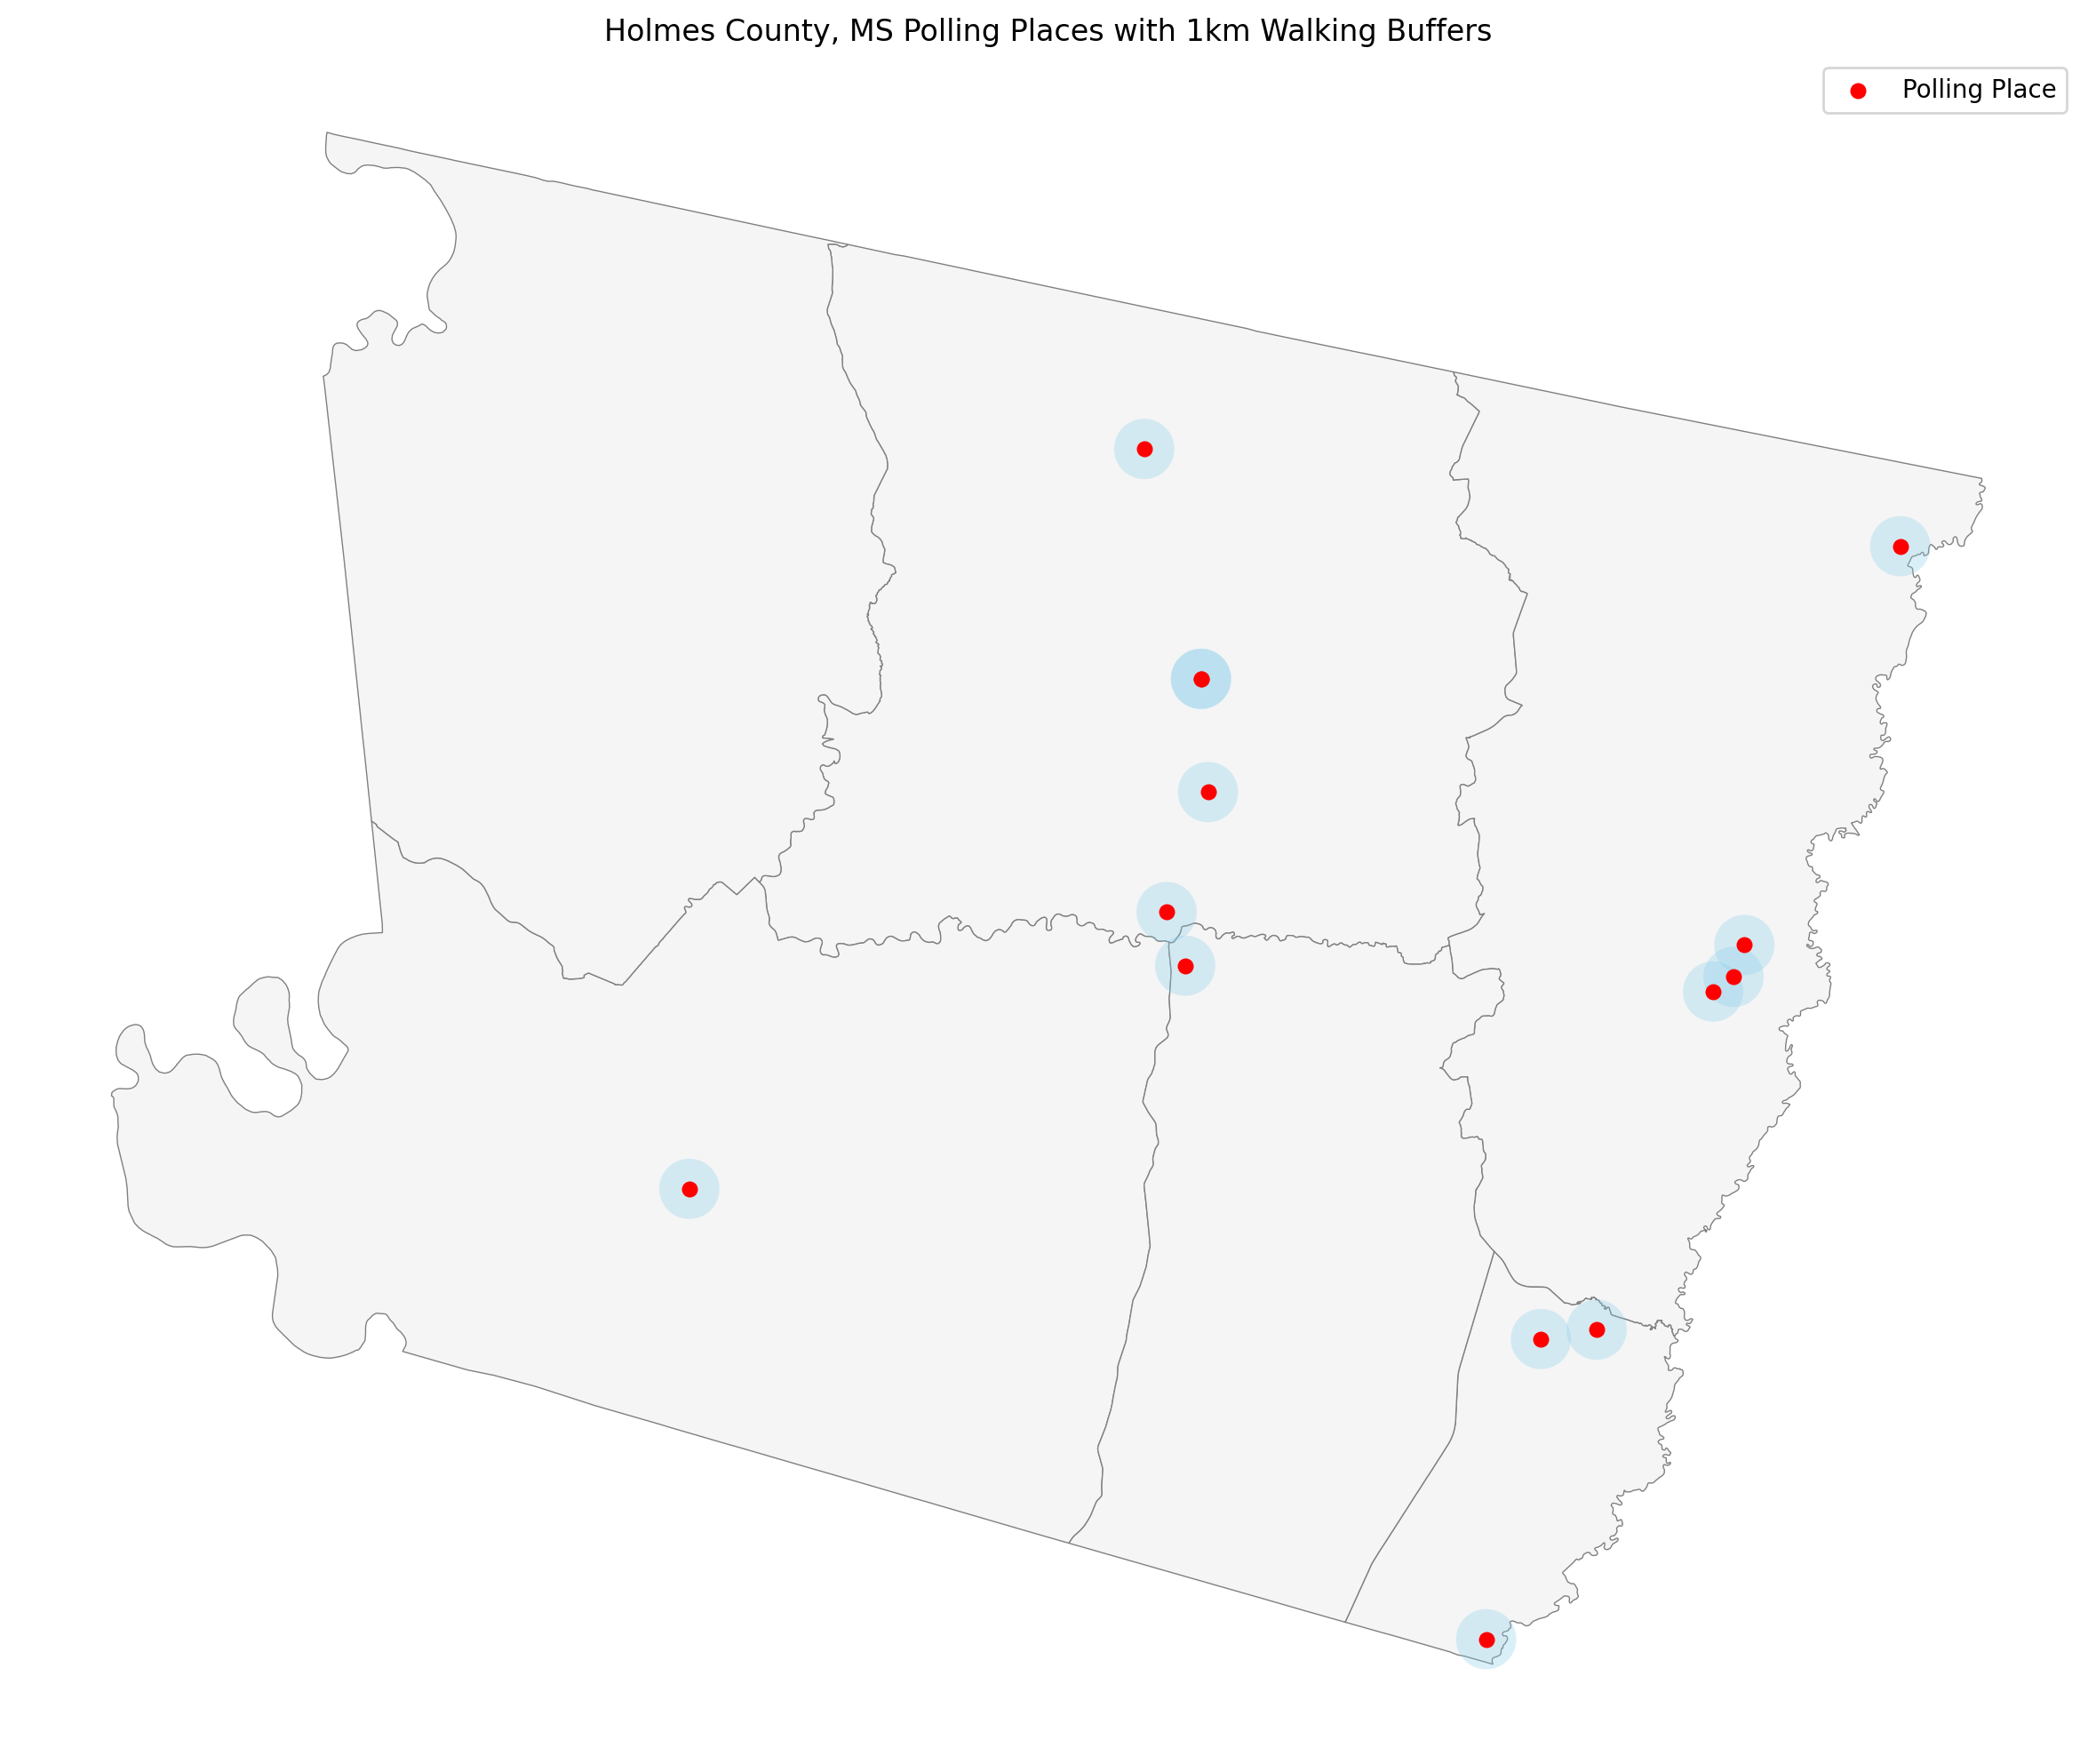

In [46]:
# Project to meters for accurate buffers (already done, but for consistency)
polling_proj = polling_gdf.to_crs(epsg=2163)
tracts_proj = holmes_tracts_gdf.to_crs(epsg=2163)

# Create 1km buffer (about 12 min walk)
polling_proj['buffer_1km'] = polling_proj.geometry.buffer(1000)

# Plot with buffers
fig, ax = plt.subplots(figsize=(12, 10))
tracts_proj.plot(ax=ax, color='whitesmoke', edgecolor='gray', linewidth=0.5)
polling_proj['buffer_1km'].plot(ax=ax, color='skyblue', alpha=0.3, edgecolor='none')
polling_proj.plot(ax=ax, color='red', markersize=30, marker='o', label='Polling Place')

plt.title("Holmes County, MS Polling Places with 1km Walking Buffers")
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()


# New Mexico

In [47]:
# download new mexico 2020 census tract shapefile
temp_file = "temp_nm_tracts_2020.zip"
urlretrieve("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_35_tract.zip", temp_file)
nm_tract_gdf_2020 = gpd.read_file(temp_file).set_index("GEOID").to_crs("EPSG:2163")
os.remove(temp_file)

In [48]:
nm_tract_gdf_2020.head(5)

STATEFP COUNTYFP TRACTCE   NAME            NAMELSAD  MTFCC  \
GEOID                                                                    
35013001207      35      013  001207  12.07  Census Tract 12.07  G5020   
35013001314      35      013  001314  13.14  Census Tract 13.14  G5020   
35013001310      35      013  001310  13.10  Census Tract 13.10  G5020   
35013001316      35      013  001316  13.16  Census Tract 13.16  G5020   
35013001208      35      013  001208  12.08  Census Tract 12.08  G5020   

            FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                
35013001207        S  139531826  142378  +32.3771603  -106.5763162   
35013001314        S  246796932       0  +32.5239438  -106.6786859   
35013001310        S    4789927       0  +32.3798068  -106.7437402   
35013001316        S    4992654       0  +32.3936470  -106.7153743   
35013001208        S   21632784   56931  +32.3599472  -106.7188392   

                                                      geometry  
GEOID                                                           
35013001207  POLYGON ((-633058.297 -1374871.836, -633011.18...  
35013001314  POLYGON ((-635381.034 -1358072.812, -635367.99...  
35013001310  POLYGON ((-637521.948 -1376005.601, -637518.83...  
35013001316  POLYGON ((-634990.719 -1375460.54, -634986.213...  
35013001208  POLYGON ((-636232.44 -1378290.489, -636231.374...

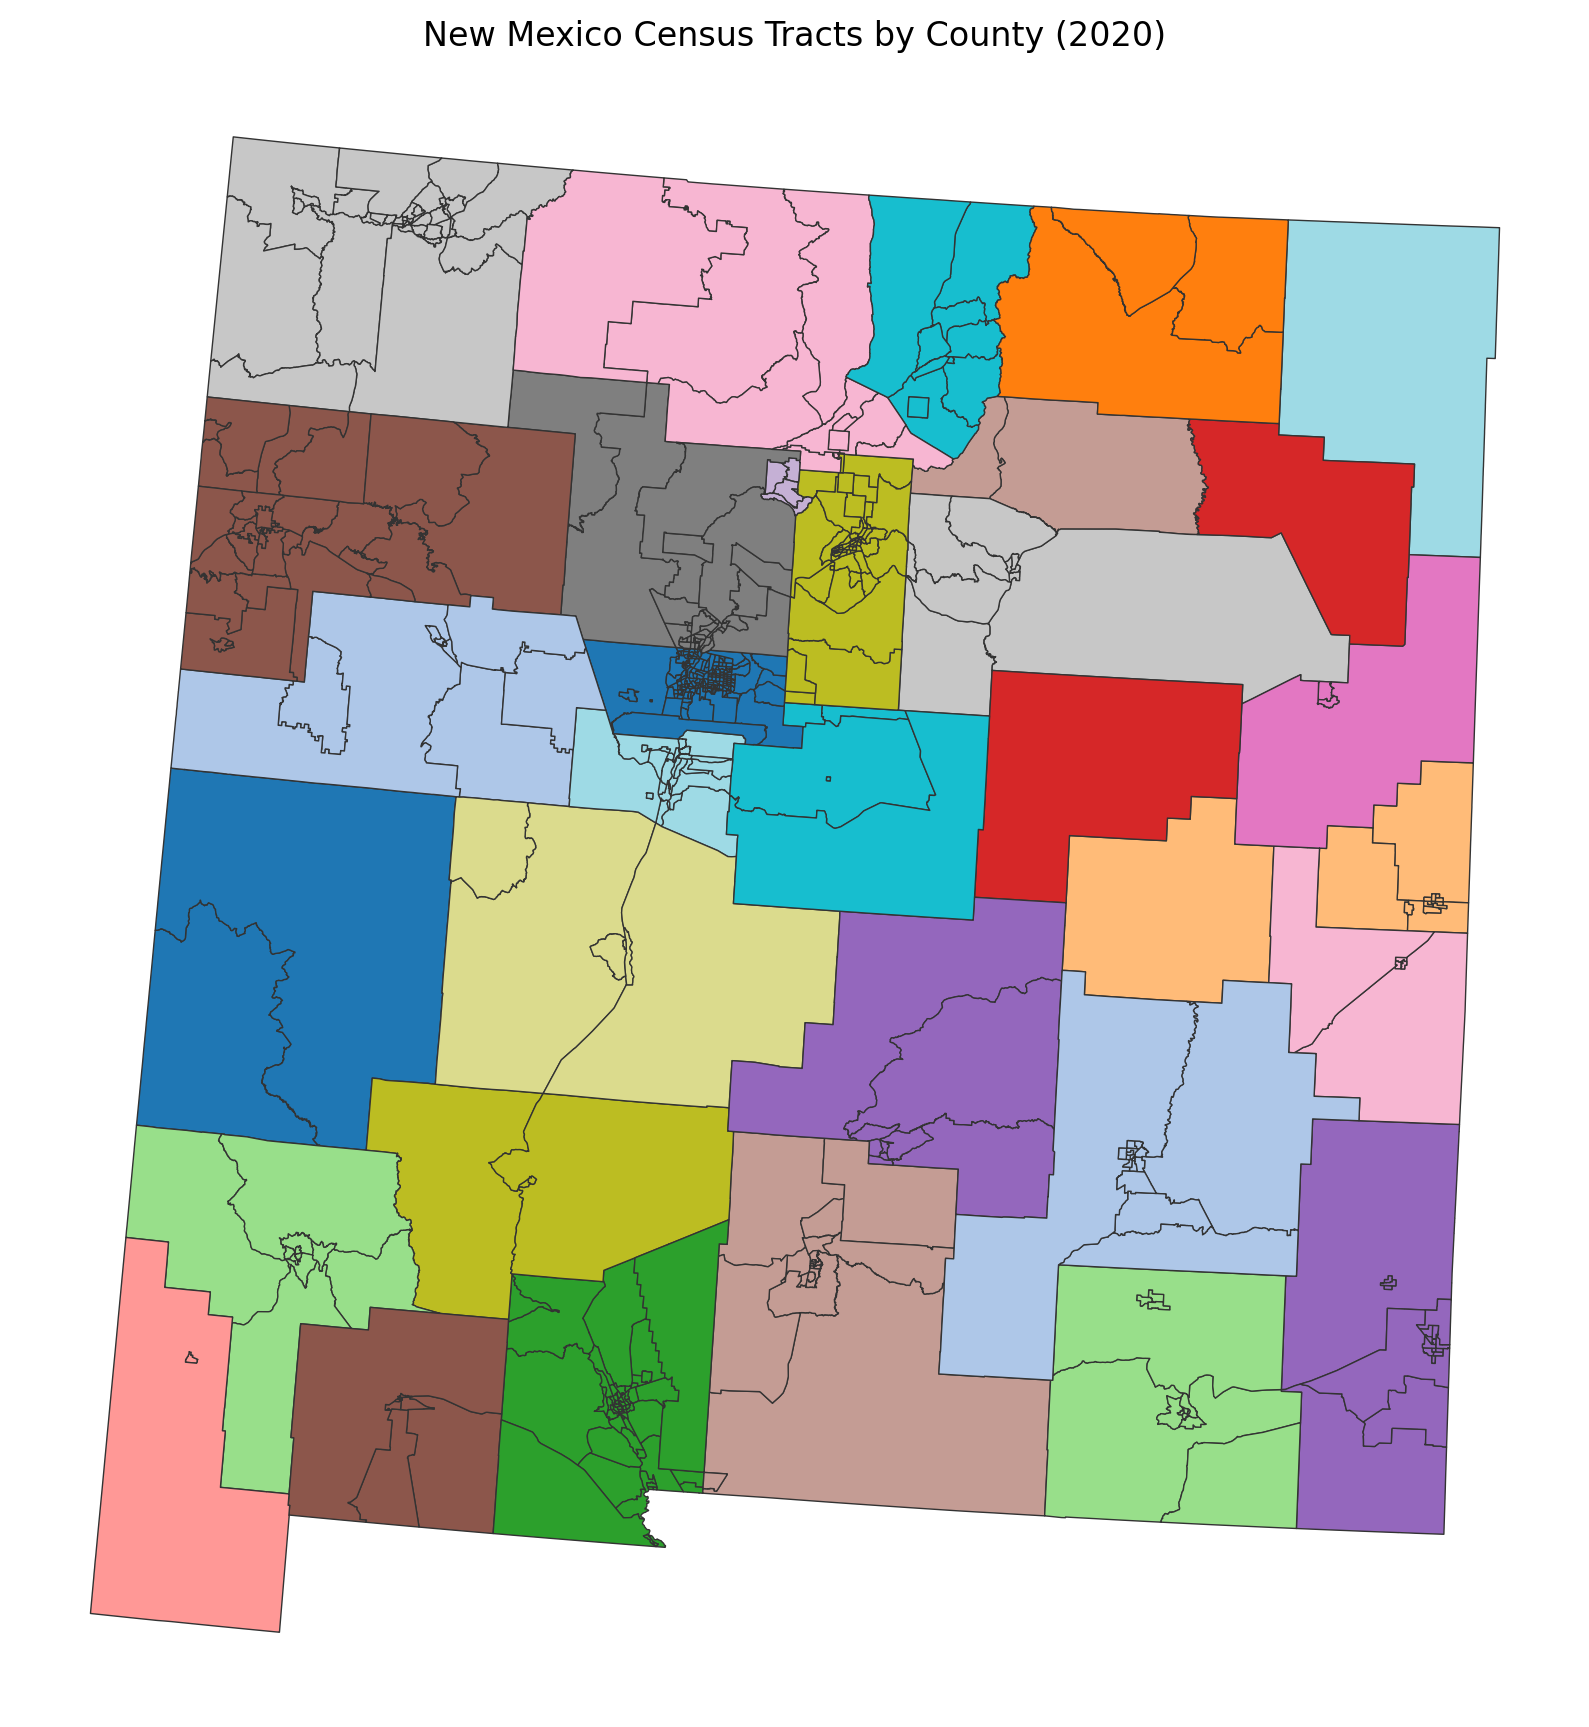

In [49]:
# plot census tracts in new mexico colored by county
nm_tract_gdf_2020.plot(
    figsize=(10, 20),
    column="COUNTYFP",
    cmap="tab20",
    edgecolor="0.2",
    linewidth=0.5
)
plt.axis("off")
plt.title("New Mexico Census Tracts by County (2020)")
plt.show()

In [50]:
# interested in mckinley county
mckinley_tract_gdf = nm_tract_gdf_2020[nm_tract_gdf_2020["COUNTYFP"] == "031"]

In [51]:
mckinley_tract_gdf.head()

STATEFP COUNTYFP TRACTCE     NAME              NAMELSAD  MTFCC  \
GEOID                                                                        
35031943602      35      031  943602  9436.02  Census Tract 9436.02  G5020   
35031945201      35      031  945201  9452.01  Census Tract 9452.01  G5020   
35031945202      35      031  945202  9452.02  Census Tract 9452.02  G5020   
35031940302      35      031  940302  9403.02  Census Tract 9403.02  G5020   
35031940301      35      031  940301  9403.01  Census Tract 9403.01  G5020   

            FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                
35031943602        S  539979432  372063  +35.5636851  -108.3125112   
35031945201        S   42446245   10562  +35.5108966  -108.7887906   
35031945202        S   41781348       0  +35.5325913  -108.8266399   
35031940302        S   28651023       0  +35.0674044  -108.8651050   
35031940301        S    4550369       0  +35.0759872  -108.8322593   

                                                      geometry  
GEOID                                                           
35031943602  POLYGON ((-776285.769 -1019034.782, -776216.77...  
35031945201  POLYGON ((-803096.948 -1013354.002, -803081.90...  
35031945202  POLYGON ((-805648.075 -1012566.835, -805638.89...  
35031940302  POLYGON ((-813158.843 -1058153.954, -813133.83...  
35031940301  POLYGON ((-806779.475 -1060693.096, -806708.06...

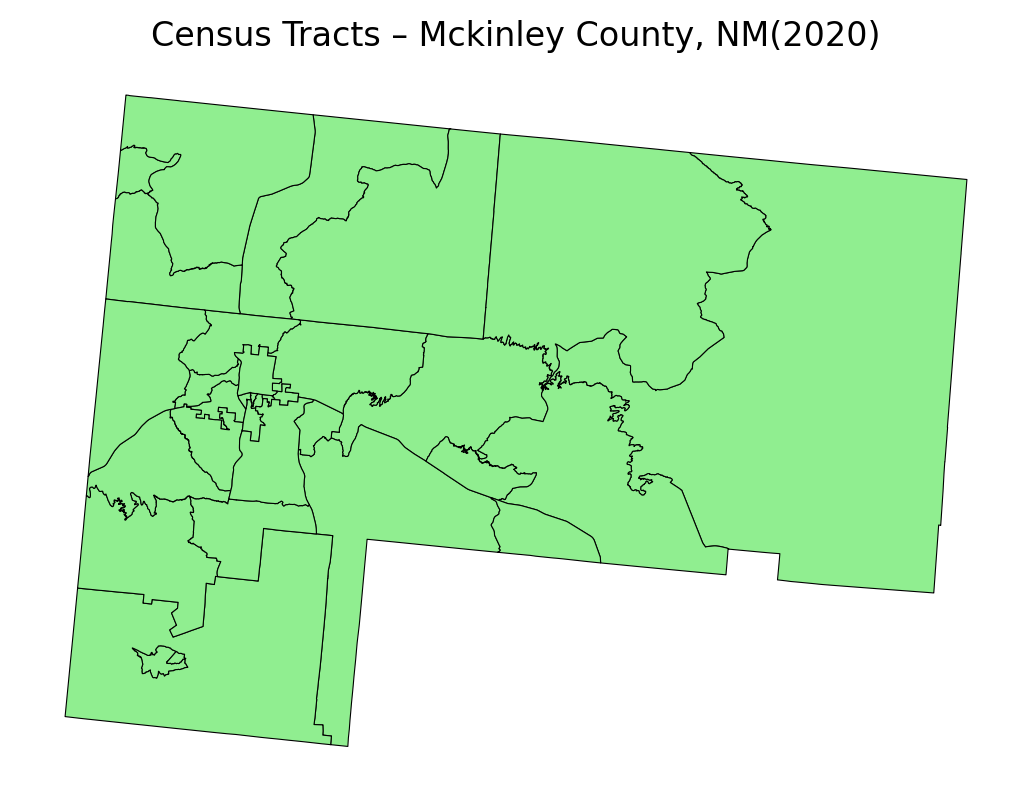

In [52]:
# plot mckinely county by census tracts
mckinley_tract_gdf.plot(
    edgecolor="black",
    linewidth=0.4,
    color="lightgreen"
)
plt.title("Census Tracts – Mckinley County, NM(2020)")
plt.axis("off")
plt.show()

In [53]:
# get acs data for mckinley county
# total households and households with no vehicles

mckinley_car_acs_raw = census.acs5.get(
    (
        "B08201_001E",  # Total households
        "B08201_002E",  # Households with no vehicle
    ),
    geo={"for": "tract:*", "in": "state:35 county:031"},
    year=2020,
)


In [54]:
# Convert to DataFrame and rename columns
mckinley_car_df = pd.DataFrame(mckinley_car_acs_raw).rename(
    columns={
        "B08201_001E": "total_households",
        "B08201_002E": "no_vehicle_households"
    }
)

# Construct GEOID with zero-padding
mckinley_car_df["GEOID"] = (
    mckinley_car_df["state"].astype(str).str.zfill(2) +  # State (2 digits)
    mckinley_car_df["county"].astype(str).str.zfill(3) +  # County (3 digits)
    mckinley_car_df["tract"].astype(str).str.zfill(6)  # Tract (6 digits)
)
mckinley_car_df = mckinley_car_df.set_index("GEOID")

# Calculate percent of households with no vehicle
mckinley_car_df["no_vehicle_pct"] = (
    100 * mckinley_car_df["no_vehicle_households"].astype(float) /
    mckinley_car_df["total_households"].astype(float)
)
mckinley_car_df = mckinley_car_df[mckinley_car_df["total_households"].astype(float) > 0]

In [55]:
mckinley_car_df.head()

total_households  no_vehicle_households state county   tract  \
GEOID                                                                       
35031940301             488.0                   83.0    35    031  940301   
35031940302            1071.0                  244.0    35    031  940302   
35031940500             292.0                   49.0    35    031  940500   
35031943500            1208.0                   69.0    35    031  943500   
35031943601             858.0                  100.0    35    031  943601   

             no_vehicle_pct  
GEOID                        
35031940301       17.008197  
35031940302       22.782446  
35031940500       16.780822  
35031943500        5.711921  
35031943601       11.655012

In [56]:
mckinley_car_gdf = mckinley_tract_gdf.join(mckinley_car_df, how='left')

In [57]:
mckinley_car_gdf.head()

STATEFP COUNTYFP TRACTCE     NAME              NAMELSAD  MTFCC  \
GEOID                                                                        
35031943602      35      031  943602  9436.02  Census Tract 9436.02  G5020   
35031945201      35      031  945201  9452.01  Census Tract 9452.01  G5020   
35031945202      35      031  945202  9452.02  Census Tract 9452.02  G5020   
35031940302      35      031  940302  9403.02  Census Tract 9403.02  G5020   
35031940301      35      031  940301  9403.01  Census Tract 9403.01  G5020   

            FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                
35031943602        S  539979432  372063  +35.5636851  -108.3125112   
35031945201        S   42446245   10562  +35.5108966  -108.7887906   
35031945202        S   41781348       0  +35.5325913  -108.8266399   
35031940302        S   28651023       0  +35.0674044  -108.8651050   
35031940301        S    4550369       0  +35.0759872  -108.8322593   

                                                      geometry  \
GEOID                                                            
35031943602  POLYGON ((-776285.769 -1019034.782, -776216.77...   
35031945201  POLYGON ((-803096.948 -1013354.002, -803081.90...   
35031945202  POLYGON ((-805648.075 -1012566.835, -805638.89...   
35031940302  POLYGON ((-813158.843 -1058153.954, -813133.83...   
35031940301  POLYGON ((-806779.475 -1060693.096, -806708.06...   

             total_households  no_vehicle_households state county   tract  \
GEOID                                                                       
35031943602             803.0                  116.0    35    031  943602   
35031945201            1197.0                   59.0    35    031  945201   
35031945202             904.0                    0.0    35    031  945202   
35031940302            1071.0                  244.0    35    031  940302   
35031940301             488.0                   83.0    35    031  940301   

             no_vehicle_pct  
GEOID                        
35031943602       14.445828  
35031945201        4.928989  
35031945202        0.000000  
35031940302       22.782446  
35031940301       17.008197

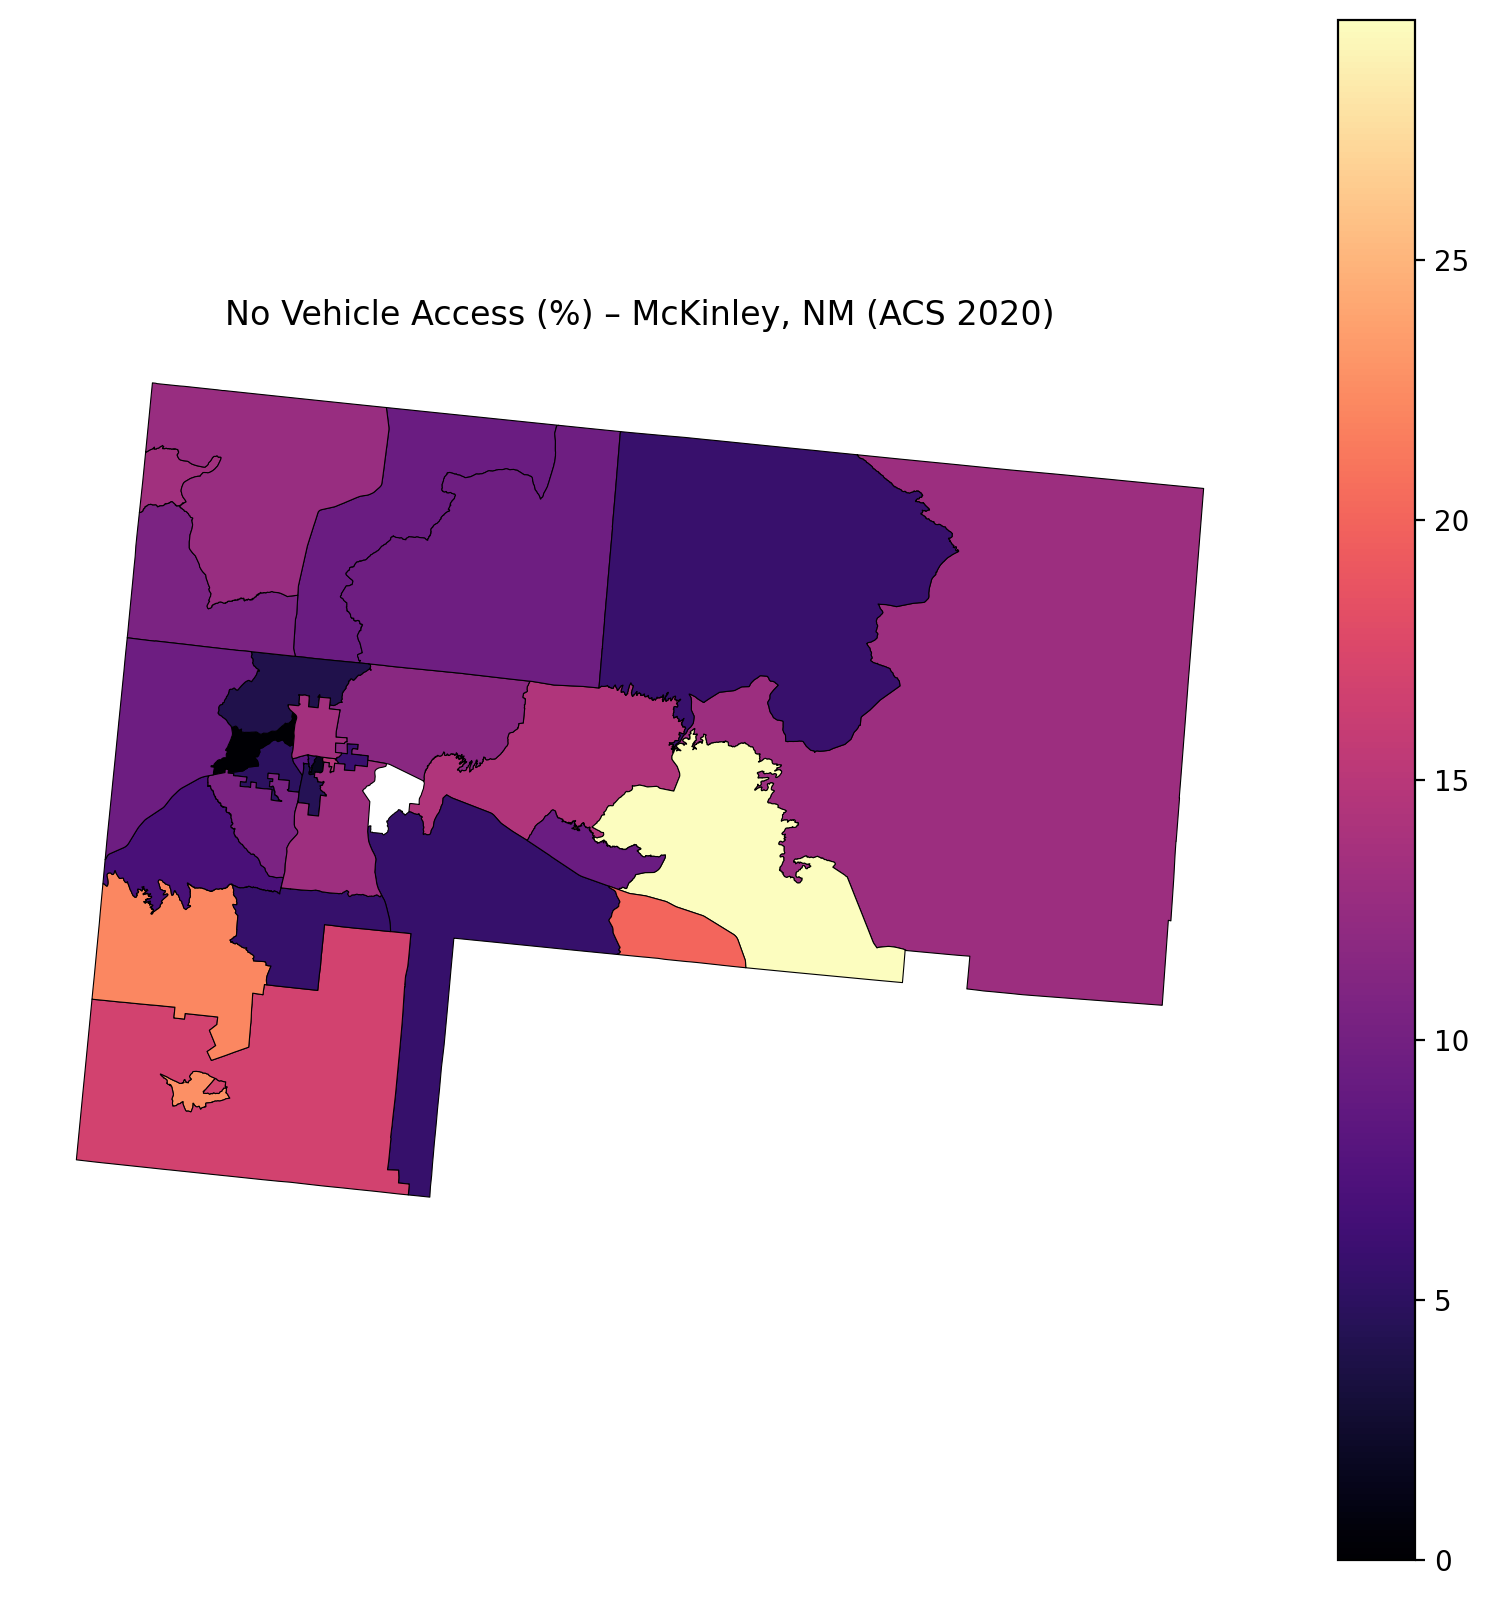

In [58]:
# creating a choropleth for holmes county by census tract - no vehicle access %
mckinley_car_gdf.plot(
    figsize=(10, 10),
    column="no_vehicle_pct",
    cmap="magma",
    edgecolor="black",
    linewidth=0.4,
    legend=True
)
plt.axis("off")
plt.title("No Vehicle Access (%) – McKinley, NM (ACS 2020)")
plt.show()

In [59]:
mckinley_income_raw = census.acs5.get(
    ("B19013_001E",),  # Median household income
    geo={"for": "tract:*", "in": "state:35 county:031"},
    year=2020,
)

# Convert to DataFrame and rename columns
mckinley_income_df = pd.DataFrame(mckinley_income_raw).rename(
    columns={"B19013_001E": "median_income"}
)

# Construct GEOID to match tract shapefile index (with zero-padding)
mckinley_income_df["GEOID"] = (
    mckinley_income_df["state"].astype(str).str.zfill(2) +
    mckinley_income_df["county"].astype(str).str.zfill(3) +
    mckinley_income_df["tract"].astype(str).str.zfill(6)
)
mckinley_income_df = mckinley_income_df.set_index("GEOID")

# Convert income to float
mckinley_income_df["median_income"] = mckinley_income_df["median_income"].astype(float)

# Join with McKinley County tract shapefile
mckinley_income_gdf = mckinley_tract_gdf.join(mckinley_income_df)


In [60]:
mckinley_income_gdf.head()

STATEFP COUNTYFP TRACTCE     NAME              NAMELSAD  MTFCC  \
GEOID                                                                        
35031943602      35      031  943602  9436.02  Census Tract 9436.02  G5020   
35031945201      35      031  945201  9452.01  Census Tract 9452.01  G5020   
35031945202      35      031  945202  9452.02  Census Tract 9452.02  G5020   
35031940302      35      031  940302  9403.02  Census Tract 9403.02  G5020   
35031940301      35      031  940301  9403.01  Census Tract 9403.01  G5020   

            FUNCSTAT      ALAND  AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                
35031943602        S  539979432  372063  +35.5636851  -108.3125112   
35031945201        S   42446245   10562  +35.5108966  -108.7887906   
35031945202        S   41781348       0  +35.5325913  -108.8266399   
35031940302        S   28651023       0  +35.0674044  -108.8651050   
35031940301        S    4550369       0  +35.0759872  -108.8322593   

                                                      geometry  median_income  \
GEOID                                                                           
35031943602  POLYGON ((-776285.769 -1019034.782, -776216.77...        31840.0   
35031945201  POLYGON ((-803096.948 -1013354.002, -803081.90...        41875.0   
35031945202  POLYGON ((-805648.075 -1012566.835, -805638.89...        37589.0   
35031940302  POLYGON ((-813158.843 -1058153.954, -813133.83...        44160.0   
35031940301  POLYGON ((-806779.475 -1060693.096, -806708.06...        43625.0   

            state county   tract  
GEOID                             
35031943602    35    031  943602  
35031945201    35    031  945201  
35031945202    35    031  945202  
35031940302    35    031  940302  
35031940301    35    031  940301

In [61]:
# Pull commute mode and travel time data (B08014) from ACS for McKinley County, NM, 2020
mckinley_commute_raw = census.acs5.get(
    (
        "B08014_001E",  # Total workers 16+ years
        "B08014_010E",  # Public transportation (excluding taxicab): Less than 30 minutes
        "B08014_011E",  # Public transportation: 30 to 59 minutes
        "B08014_012E",  # Public transportation: 60 or more minutes
    ),
    geo={"for": "tract:*", "in": "state:35 county:031"},
    year=2020,
)

# Convert to DataFrame and rename columns
mckinley_commute_df = pd.DataFrame(mckinley_commute_raw).rename(columns={
    "B08014_001E": "total_workers",
    "B08014_010E": "public_transit_lt_30",
    "B08014_011E": "public_transit_30_59",
    "B08014_012E": "public_transit_60_plus"
})

# Construct GEOID to match tract shapefile index (with zero-padding)
mckinley_commute_df["GEOID"] = (
    mckinley_commute_df["state"].astype(str).str.zfill(2) +
    mckinley_commute_df["county"].astype(str).str.zfill(3) +
    mckinley_commute_df["tract"].astype(str).str.zfill(6)
)
mckinley_commute_df = mckinley_commute_df.set_index("GEOID")

# Convert columns to numeric
for col in ["total_workers", "public_transit_lt_30", "public_transit_30_59", "public_transit_60_plus"]:
    mckinley_commute_df[col] = pd.to_numeric(mckinley_commute_df[col], errors="coerce")

# Calculate total public transit users
mckinley_commute_df["public_transit_total"] = (
    mckinley_commute_df["public_transit_lt_30"] +
    mckinley_commute_df["public_transit_30_59"] +
    mckinley_commute_df["public_transit_60_plus"]
)

# Compute % of workers using public transportation
mckinley_commute_df["pct_public_transit"] = (
    100 * mckinley_commute_df["public_transit_total"] /
    mckinley_commute_df["total_workers"]
)

# Drop rows where total_workers is zero or missing
mckinley_commute_df = mckinley_commute_df[mckinley_commute_df["total_workers"] > 0]



In [62]:
mckinley_commute_df.head()

total_workers  public_transit_lt_30  public_transit_30_59  \
GEOID                                                                    
35031940301          765.0                  65.0                  69.0   
35031940302         1727.0                 123.0                 284.0   
35031940500          475.0                  73.0                  89.0   
35031943500         1351.0                 114.0                 196.0   
35031943601          936.0                  86.0                  78.0   

             public_transit_60_plus state county   tract  \
GEOID                                                      
35031940301                   151.0    35    031  940301   
35031940302                   169.0    35    031  940302   
35031940500                     8.0    35    031  940500   
35031943500                    69.0    35    031  943500   
35031943601                    95.0    35    031  943601   

             public_transit_total  pct_public_transit  
GEOID                                                  
35031940301                 285.0           37.254902  
35031940302                 576.0           33.352635  
35031940500                 170.0           35.789474  
35031943500                 379.0           28.053294  
35031943601                 259.0           27.670940

# CVAP

In [63]:
# import cvap data from census
cvap = pd.read_csv("https://raw.githubusercontent.com/PUBPOL-2130/projects/main/E2/County.csv", encoding="latin1")

# Filter for four target counties and "Total" population row
filtered = cvap[
    cvap['geoname'].str.contains(
        "Holmes County, Mississippi|McKinley County",
        case=False, na=False
    ) &
    (cvap['lntitle'].str.strip().str.lower() == "total")
]

# Keep only county name and total population estimate
result = filtered[['geoname', 'tot_est']]

# Display the result
print(result)


                           geoname  tot_est
18551   Holmes County, Mississippi    17415
23569  McKinley County, New Mexico    71955


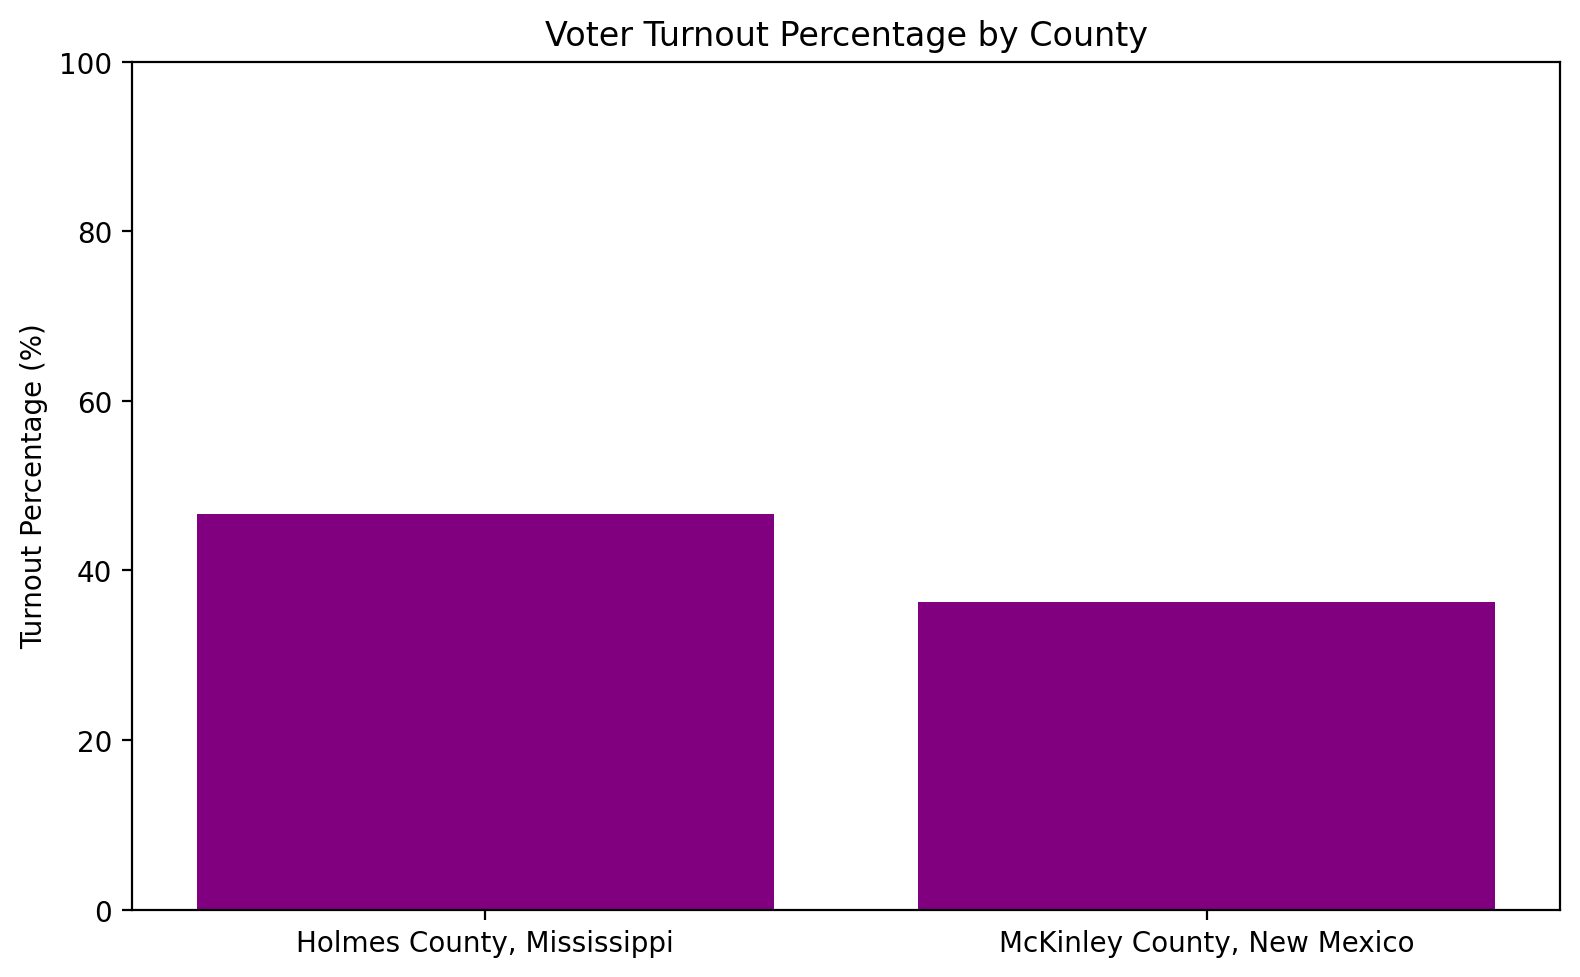

In [64]:
data = {
    "geoname": ["Holmes County, Mississippi", "McKinley County, New Mexico"],
    "tot_est": [17415, 71955],   # Updated total estimates
    "votes_cast": [8115, 26096]  # Given votes cast
}
df = pd.DataFrame(data)

df["turnout_pct"] = (df["votes_cast"] / df["tot_est"]) * 100

# Plot turnout percentage
plt.figure(figsize=(8, 5))
plt.bar(df["geoname"], df["turnout_pct"], color='purple')
plt.title("Voter Turnout Percentage by County")
plt.ylabel("Turnout Percentage (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


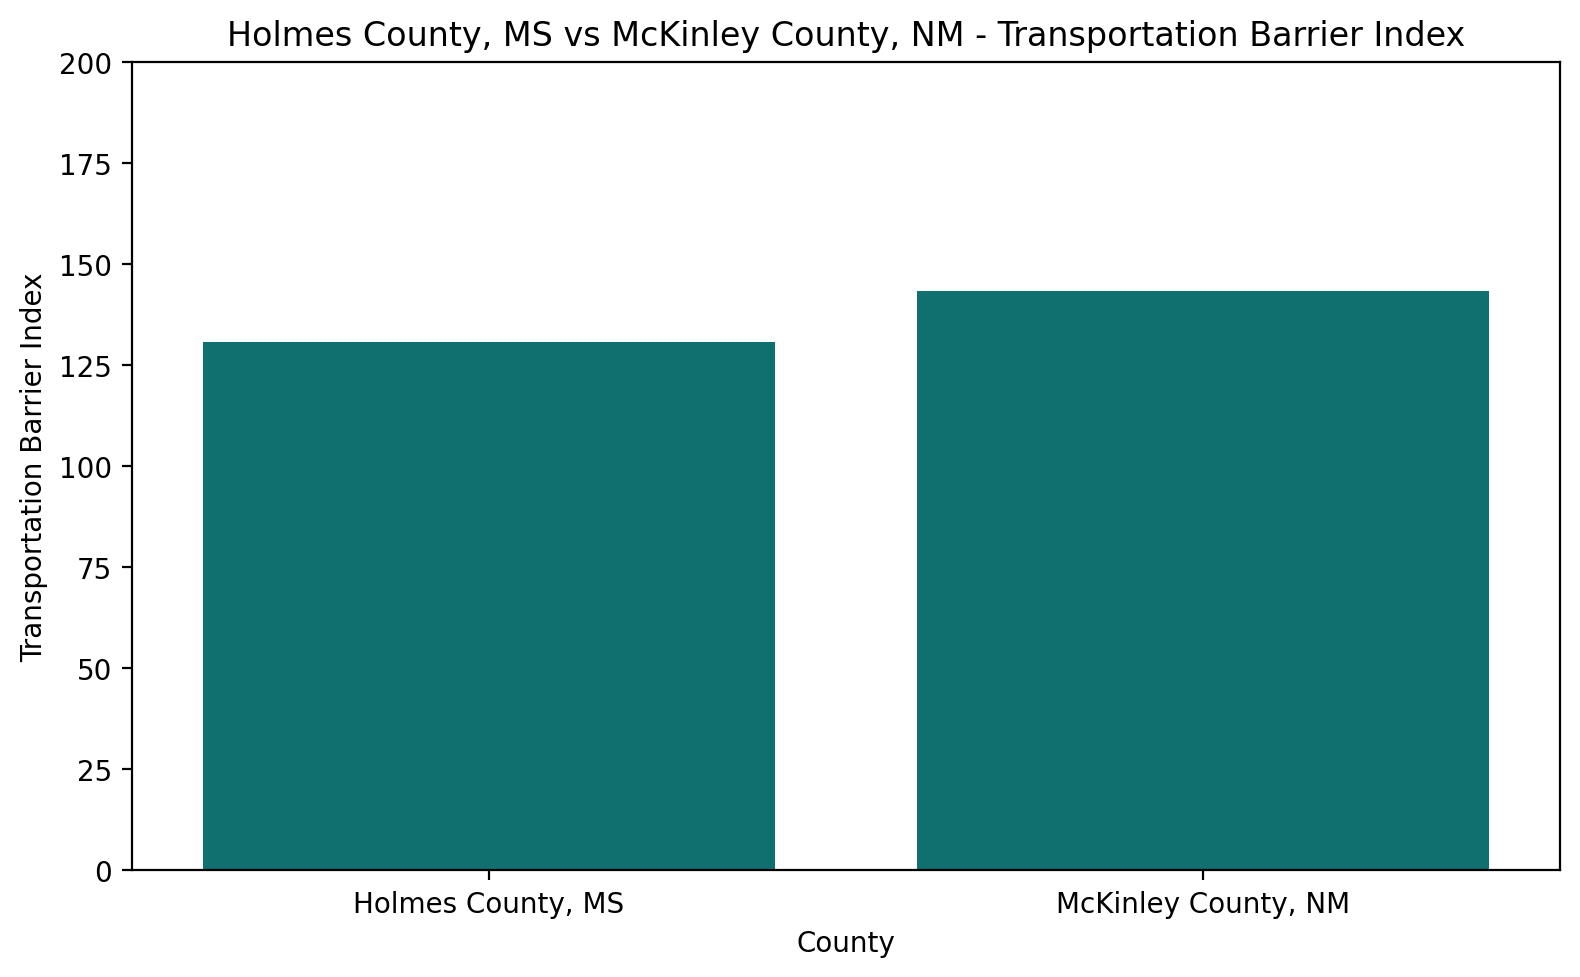

In [65]:
# Calculate county-level Transportation Barrier Index
ms_tbi = calculate_tbi_by_county("28", "Mississippi")
nm_tbi = calculate_tbi_by_county("35", "New Mexico")

# Filter for Holmes County, MS and McKinley County, NM
holmes_tbi = ms_tbi[ms_tbi["FIPS"] == "28051"]
mckinley_tbi = nm_tbi[nm_tbi["FIPS"] == "35031"]

# Combine into single dataframe
tbi_df = pd.concat([holmes_tbi, mckinley_tbi])
tbi_df["County"] = ["Holmes County, MS", "McKinley County, NM"]

# Plot Transportation Barrier Index
plt.figure(figsize=(8, 5))
sns.barplot(data=tbi_df, x="County", y="Transportation_Barrier_Index", color="teal")
plt.title("Holmes County, MS vs McKinley County, NM - Transportation Barrier Index")
plt.ylabel("Transportation Barrier Index")
plt.ylim(0, 200)
plt.tight_layout()
plt.show()